In [1]:
import os
import glob
import more_itertools

import pandas as pd
import numpy as np

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import Align 
from Bio import SeqIO
from Bio import AlignIO

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as patches

import verify_sanger.sanger_utilities as vs
from verify_sanger.PlottableRecord import PlottableRecord

import seaborn as sns
sns.set()
# set global default style:
sns.set_style("white")
sns.set_style("ticks", {'xtick.direction':'in', 'xtick.top':True, 'ytick.direction':'in', 'ytick.right':True, })
#sns.set_style({"axes.labelsize": 20, "xtick.labelsize" : 16, "ytick.labelsize" : 16})

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.edgecolor'] = 'k'

plt.rcParams['figure.max_open_warning'] = False

%load_ext autoreload
%autoreload 2

In [2]:
notebook_dir = os.getcwd()
notebook_dir

'C:\\Users\\djross\\Documents\\Python Scripts\\verify_sanger\\example data'

In [3]:
data_dir = notebook_dir + '\\data'
data_dir

'C:\\Users\\djross\\Documents\\Python Scripts\\verify_sanger\\example data\\data'

In [4]:
glob.glob('*.csv')

['Sanger clones_report.csv', 'Sanger clones_report.Object-oriented.csv']

In [5]:
clone_file = 'Sanger clones.csv'

In [6]:
# Get the input file info from the .csv file
os.chdir(data_dir)
align_frame = pd.read_csv(clone_file)
align_frame['forward_sanger_file'] = [ x+'.ab1' if type(x) is str else '' for x in  align_frame.forward_sanger_file ]
align_frame['reverse_sanger_file'] = [ x+'.ab1' if type(x) is str else '' for x in  align_frame.reverse_sanger_file ]
align_frame

variant clone forward_sanger_file  \
0        pVER-IPTG-WT(F161V/I83F)     A      1FCFDAA056.ab1   
1        pVER-IPTG-WT(F161V/I83F)     B      1FCFDAA055.ab1   
2             pVER-IPTG-WT(G200C)     A      1FCDDAA051.ab1   
3             pVER-IPTG-WT(G200C)     B      1FCDDAA050.ab1   
4        pVER-IPTG-WT(G200C/I83F)     A      1FCFDAA062.ab1   
5        pVER-IPTG-WT(G200C/I83F)     B      1FCFDAA061.ab1   
6        pVER-IPTG-WT(G200C/S97T)     A      1FCFDAA004.ab1   
7        pVER-IPTG-WT(G200C/S97T)     B      1FCFDAA003.ab1   
8         pVER-IPTG-WT(I83M/S69T)     A      1FCFDAA064.ab1   
9         pVER-IPTG-WT(I83M/S69T)     B      1FCFDAA063.ab1   
10  pVER-IPTG-WT(I83M/S97T/V136E)     A      1FCFDAA058.ab1   
11  pVER-IPTG-WT(I83M/S97T/V136E)     B      1FCFDAA057.ab1   
12       pVER-IPTG-WT(Q181H/S70R)     A      1FCFDAA068.ab1   
13       pVER-IPTG-WT(Q181H/S70R)     B      1FCFDAA067.ab1   

   reverse_sanger_file  
0       1FCFDAA032.ab1  
1       1FCFDAA031.ab1  
2       1FCDDAA029.ab1  
3       1FCDDAA028.ab1  
4       1FCFDAA038.ab1  
5       1FCFDAA037.ab1  
6       1FCDDAA080.ab1  
7       1FCDDAA079.ab1  
8       1FCFDAA040.ab1  
9       1FCFDAA039.ab1  
10      1FCFDAA034.ab1  
11      1FCFDAA033.ab1  
12      1FCFDAA044.ab1  
13      1FCFDAA043.ab1

In [7]:
# Check for duplicate or missing file names
df = align_frame[align_frame.forward_sanger_file=='']
df = df[df.reverse_sanger_file!='']
display(df)

df = align_frame[align_frame.forward_sanger_file!='']
df = df[df.reverse_sanger_file=='']
display(df)

Empty DataFrame
Columns: [variant, clone, forward_sanger_file, reverse_sanger_file]
Index: []

Empty DataFrame
Columns: [variant, clone, forward_sanger_file, reverse_sanger_file]
Index: []

In [8]:
df = align_frame[align_frame.forward_sanger_file!='']
print(len(df))
print(len(np.unique(df.forward_sanger_file)))
print(len(np.unique(df.reverse_sanger_file)))

14
14
14


In [9]:
# Get the reference sequence
os.chdir(data_dir)
ref_record = SeqIO.read('pVER-WT-Sanger.gb', "genbank")
#ref_record = SeqIO.read('LacI-WT_with_adapters.gb', "genbank")
ref_feature = 'lacI CDS'

reference_feat = None
for feat in ref_record.features:
    #print(feat.qualifiers['label'])
    if feat.qualifiers['label'][0] == ref_feature:
        reference_feat = feat
        break

# These are the start and end positions of the insert CDS in the reference sequence 
ref_b0, ref_b1 = reference_feat.location.start.position, reference_feat.location.end.position
ref_length = ref_b1 - ref_b0

len(ref_record), ref_length, reference_feat

(1562,
 1083,
 SeqFeature(FeatureLocation(ExactPosition(176), ExactPosition(1259), strand=1), type='CDS'))

In [10]:
# Run pairwise alignment of forward and reverse Sanger reads
os.chdir(data_dir)

trim = 0.01

is_good_sanger = []
sanger_start = []
alignment_list = []

for i, (row_ind, row) in enumerate(align_frame.iterrows()):
    if row.forward_sanger_file!='':
        try:
            record1 = SeqIO.read(row.forward_sanger_file, "abi")
            record1 = PlottableRecord(record1)
            ind = vs.mott_trimming_fr(record1, trim=trim)
            annotations = record1.annotations
            annotations.pop('abif_raw')
            record1 = record1[ind[0]:ind[1]+1]
            record1.annotations = annotations
            
            sang_start = record1.annotations['run_start']
            sanger_start.append(sang_start)
            
            record2 = SeqIO.read(row.reverse_sanger_file, "abi")
            record2 = PlottableRecord(record2)
            ind = vs.mott_trimming_fr(record2, trim=trim)
            annotations = record2.annotations
            annotations.pop('abif_raw')
            record2 = record2[ind[0]:ind[1]+1]
            record2.annotations = annotations
            record2 = record2.reverse_complement()

            print(f'{row_ind}, {row.variant} clone {row.clone}')
            a = vs.align_sanger(record1, record2, verbose=True)
            
            is_good = vs.is_good_sanger(a)
            is_good_sanger.append(is_good)
            print(f'is_good_sanger: {is_good}')
            print()
        except FileNotFoundError:
            a = None
            is_good_sanger.append(None)
            sanger_start.append(None)
    else:
        a = None
        is_good_sanger.append(None)
        sanger_start.append(None)
        
    alignment_list.append(a)

align_frame['alignment'] = alignment_list
align_frame['is_good_sanger'] = is_good_sanger
align_frame['sanger_start'] = sanger_start
        
os.chdir(notebook_dir)

0, pVER-IPTG-WT(F161V/I83F) clone A
2 alignment(s) found with score: 1253.0
(((0, 4), (4, 253)), ((676, 680), (681, 930)))
1 gap(s) in sequence no. 1
253 matches in alignment
0 mismatches in alignment
is_good_sanger: True

1, pVER-IPTG-WT(F161V/I83F) clone B
1 alignment(s) found with score: 1070.0
(((510, 724),), ((0, 214),))
no gaps
214 matches in alignment
0 mismatches in alignment
is_good_sanger: True

2, pVER-IPTG-WT(G200C) clone A
1 alignment(s) found with score: 1535.0
(((409, 716),), ((0, 307),))
no gaps
307 matches in alignment
0 mismatches in alignment
is_good_sanger: True

3, pVER-IPTG-WT(G200C) clone B
2 alignment(s) found with score: 0.0
((), ())
no gaps
0 matches in alignment
0 mismatches in alignment
is_good_sanger: False

4, pVER-IPTG-WT(G200C/I83F) clone A
3 alignment(s) found with score: 1243.0
(((611, 832), (833, 863)), ((0, 221), (221, 251)))
1 gap(s) in sequence no. 2
251 matches in alignment
0 mismatches in alignment
is_good_sanger: True

5, pVER-IPTG-WT(G200C/I83F

In [11]:
# Bug in Pandas.display, won't show frame if 'alignment' column is included; possibly an issue with the way
# __getitem__ and __len__ are defined in the biopython PairwiseAlignment class.
align_frame

In [12]:
display_cols = ['variant', 'clone', 'forward_sanger_file', 'reverse_sanger_file',
                'sanger_start', 'is_good_sanger']

In [13]:
align_frame[display_cols]

variant clone forward_sanger_file  \
0        pVER-IPTG-WT(F161V/I83F)     A      1FCFDAA056.ab1   
1        pVER-IPTG-WT(F161V/I83F)     B      1FCFDAA055.ab1   
2             pVER-IPTG-WT(G200C)     A      1FCDDAA051.ab1   
3             pVER-IPTG-WT(G200C)     B      1FCDDAA050.ab1   
4        pVER-IPTG-WT(G200C/I83F)     A      1FCFDAA062.ab1   
5        pVER-IPTG-WT(G200C/I83F)     B      1FCFDAA061.ab1   
6        pVER-IPTG-WT(G200C/S97T)     A      1FCFDAA004.ab1   
7        pVER-IPTG-WT(G200C/S97T)     B      1FCFDAA003.ab1   
8         pVER-IPTG-WT(I83M/S69T)     A      1FCFDAA064.ab1   
9         pVER-IPTG-WT(I83M/S69T)     B      1FCFDAA063.ab1   
10  pVER-IPTG-WT(I83M/S97T/V136E)     A      1FCFDAA058.ab1   
11  pVER-IPTG-WT(I83M/S97T/V136E)     B      1FCFDAA057.ab1   
12       pVER-IPTG-WT(Q181H/S70R)     A      1FCFDAA068.ab1   
13       pVER-IPTG-WT(Q181H/S70R)     B      1FCFDAA067.ab1   

   reverse_sanger_file         sanger_start  is_good_sanger  
0       1FCFDAA032.ab1  2021-04-26 19:59:48            True  
1       1FCFDAA031.ab1  2021-04-26 19:59:48            True  
2       1FCDDAA029.ab1  2021-05-14 02:41:37            True  
3       1FCDDAA028.ab1  2021-05-14 02:41:37           False  
4       1FCFDAA038.ab1  2021-04-26 19:59:48            True  
5       1FCFDAA037.ab1  2021-04-26 19:59:48           False  
6       1FCDDAA080.ab1  2021-05-05 22:53:10           False  
7       1FCDDAA079.ab1  2021-05-05 22:53:10           False  
8       1FCFDAA040.ab1  2021-04-26 19:59:48            True  
9       1FCFDAA039.ab1  2021-04-26 19:59:48           False  
10      1FCFDAA034.ab1  2021-04-26 19:59:48            True  
11      1FCFDAA033.ab1  2021-04-26 19:59:48            True  
12      1FCFDAA044.ab1  2021-04-26 19:59:48            True  
13      1FCFDAA043.ab1  2021-04-26 19:59:48            True

In [14]:
# Run pairwise alignment between reference sequence and consensus from Sanger
ref_alignment = []
mismatch_list = []
close_insert = []
good_insert = []
gap_in_ref = []
bad_mutation = []

max_mutations = len(ref_record) - ref_length + 20
print(f'max_mutations: {max_mutations}')
print()
min_mismatch_qual = 30

for row_ind, row in align_frame.iterrows():
    
    a = row.alignment
    
    if row.alignment is not None: #row.is_good_sanger:
        print(f'{row_ind}, {row.variant} clone {row.clone}')
        test_seq = row.alignment.consensus_seq.reverse_complement()
        ref_align = vs.align_sanger(ref_record, test_seq, verbose=True, ungap=True)
        
        feat_dict = {}
        for feat in ref_align.record1.features:
            feat_dict[feat.qualifiers['label'][0]] = (feat.location.start.position, feat.location.end.position)
        critical_range = (feat_dict['PlacI'][0], feat_dict['Native araC terminator'][1])
        mutated_range = (feat_dict['lacI CDS'][0], feat_dict['lacI CDS'][1])
        
        ref_alignment.append(ref_align)
        mis_match = vs.num_matches(ref_align)
        gap_count = vs.num_gaps(ref_align)
        gap = gap_count>0
        gap = False
        bad_mut = False
        for i in ref_align.mismatch_ind:
            if (ref_align.align_str[1][i]=='-') and (i>=critical_range[0]) and (i<critical_range[1]):
                gap = True
            sel0 = ref_align.align_str[1][i]!='|'
            sel1 = (i>=critical_range[0]) and (i<mutated_range[0])
            sel2 = (i>=mutated_range[1]) and (i<critical_range[1])
            if sel0 and (sel1 or sel2):
                bad_mut = True
                if len(ref_align.mismatch_ind)<20:
                    qual = ref_align.record2.quality[i]
                    print(f'Possible mutation outside CDS, at {i}, with Sanger quality {qual}')
                    if qual < min_mismatch_qual:
                        align_frame.loc[row_ind, 'is_good_sanger'] = False
        gap_in_ref.append(gap)
        bad_mutation.append(bad_mut)
        
        if row.is_good_sanger:
            close_ins = mis_match[0]>=len(ref_record)-max_mutations
            good_ins = (close_ins) and (not gap) and (not bad_mut)
        else:
            close_ins = None
            good_ins = None
        close_insert.append(close_ins)
        good_insert.append(good_ins)
        mismatch_list.append(mis_match)
        
        temp = align_frame.loc[row_ind, 'is_good_sanger']
        print(f'is_good_sanger: {temp}')
        print(f'is_close_insert: {close_ins}')
        print(f'is_good_insert: {good_ins}')
        print(f'gap_in_ref_align: {gap}')
        if bad_mut: print('mutation or indel outside CDS')
        print()
        
    else:
        ref_alignment.append(None)
        close_insert.append(None)
        good_insert.append(None)
        gap_in_ref.append(None)
        bad_mutation.append(None)
        
align_frame['ref_alignment'] = ref_alignment
align_frame['is_close_insert'] = close_insert
align_frame['is_good_insert'] = good_insert
align_frame['gap_in_ref_align'] = gap_in_ref
align_frame['bad_mutation'] = bad_mutation

max_mutations: 499

0, pVER-IPTG-WT(F161V/I83F) clone A
2123366400 alignment(s) found with score: 692.0
(((994, 1000), (1000, 1003), (1005, 1009), (1009, 1020), (1020, 1028), (1030, 1037), (1038, 1047), (1047, 1050), (1050, 1052), (1052, 1056), (1056, 1058), (1058, 1059), (1059, 1068), (1070, 1076), (1077, 1080), (1080, 1086), (1086, 1095), (1095, 1097), (1097, 1106), (1106, 1111), (1111, 1121), (1122, 1125), (1125, 1130), (1130, 1132), (1133, 1137), (1137, 1139), (1139, 1143), (1148, 1152), (1152, 1153), (1154, 1159), (1159, 1166), (1166, 1167), (1167, 1170), (1170, 1177), (1177, 1180), (1180, 1183), (1183, 1187), (1187, 1189), (1189, 1198), (1198, 1207), (1207, 1214), (1216, 1217), (1217, 1220), (1220, 1223), (1223, 1226), (1226, 1228), (1228, 1231), (1231, 1233), (1235, 1240), (1241, 1245), (1247, 1249), (1249, 1251), (1251, 1252), (1252, 1262), (1262, 1264), (1264, 1266), (1266, 1272), (1272, 1280), (1280, 1292), (1292, 1299), (1299, 1302), (1302, 1303), (1303, 1310), (1310, 1562))

In [15]:
display_cols += ['is_good_insert', 'gap_in_ref_align', 'bad_mutation']

In [16]:
align_frame[display_cols]

variant clone forward_sanger_file  \
0        pVER-IPTG-WT(F161V/I83F)     A      1FCFDAA056.ab1   
1        pVER-IPTG-WT(F161V/I83F)     B      1FCFDAA055.ab1   
2             pVER-IPTG-WT(G200C)     A      1FCDDAA051.ab1   
3             pVER-IPTG-WT(G200C)     B      1FCDDAA050.ab1   
4        pVER-IPTG-WT(G200C/I83F)     A      1FCFDAA062.ab1   
5        pVER-IPTG-WT(G200C/I83F)     B      1FCFDAA061.ab1   
6        pVER-IPTG-WT(G200C/S97T)     A      1FCFDAA004.ab1   
7        pVER-IPTG-WT(G200C/S97T)     B      1FCFDAA003.ab1   
8         pVER-IPTG-WT(I83M/S69T)     A      1FCFDAA064.ab1   
9         pVER-IPTG-WT(I83M/S69T)     B      1FCFDAA063.ab1   
10  pVER-IPTG-WT(I83M/S97T/V136E)     A      1FCFDAA058.ab1   
11  pVER-IPTG-WT(I83M/S97T/V136E)     B      1FCFDAA057.ab1   
12       pVER-IPTG-WT(Q181H/S70R)     A      1FCFDAA068.ab1   
13       pVER-IPTG-WT(Q181H/S70R)     B      1FCFDAA067.ab1   

   reverse_sanger_file         sanger_start  is_good_sanger is_good_insert  \
0       1FCFDAA032.ab1  2021-04-26 19:59:48            True          False   
1       1FCFDAA031.ab1  2021-04-26 19:59:48            True           True   
2       1FCDDAA029.ab1  2021-05-14 02:41:37            True           True   
3       1FCDDAA028.ab1  2021-05-14 02:41:37           False           None   
4       1FCFDAA038.ab1  2021-04-26 19:59:48            True           True   
5       1FCFDAA037.ab1  2021-04-26 19:59:48           False           None   
6       1FCDDAA080.ab1  2021-05-05 22:53:10           False           None   
7       1FCDDAA079.ab1  2021-05-05 22:53:10           False           None   
8       1FCFDAA040.ab1  2021-04-26 19:59:48            True          False   
9       1FCFDAA039.ab1  2021-04-26 19:59:48           False           None   
10      1FCFDAA034.ab1  2021-04-26 19:59:48           False          False   
11      1FCFDAA033.ab1  2021-04-26 19:59:48           False          False   
12      1FCFDAA044.ab1  2021-04-26 19:59:48            True          False   
13      1FCFDAA043.ab1  2021-04-26 19:59:48            True          False   

    gap_in_ref_align  bad_mutation  
0               True          True  
1              False         False  
2              False         False  
3              False         False  
4              False         False  
5               True         False  
6               True          True  
7               True          True  
8               True          True  
9               True         False  
10             False          True  
11             False          True  
12              True         False  
13              True         False

In [17]:
# Find mutation codes
mut_codes = []
indel_codes = []

for row_ind, row in align_frame.iterrows():
    
    a = row.alignment
    
    if (row.is_good_sanger) and (row.is_good_insert):
        print(f'{row_ind}, {row.variant} clone {row.clone}')
        
        amino_align, subs, indels = vs.find_mutations_vs_reference(row.ref_alignment, 'lacI CDS', verbose=True)
        print(subs)
        print(indels)
        print()
        
        mut_codes.append(subs)
        indel_codes.append(indels)
    else:
        mut_codes.append([])
        indel_codes.append([])
        
align_frame['substitution_codes'] = mut_codes
align_frame['indel_codes'] = indel_codes

1, pVER-IPTG-WT(F161V/I83F) clone B
1 alignment(s) found with score: 1777.0
(((0, 361),), ((0, 361),))
no gaps
359 matches in alignment
2 mismatches in alignment
['I83F', 'F161V']
[]

2, pVER-IPTG-WT(G200C) clone A
1 alignment(s) found with score: 1791.0
(((0, 361),), ((0, 361),))
no gaps
360 matches in alignment
1 mismatches in alignment
['G200C']
[]

4, pVER-IPTG-WT(G200C/I83F) clone A
1 alignment(s) found with score: 1777.0
(((0, 361),), ((0, 361),))
no gaps
359 matches in alignment
2 mismatches in alignment
['I83F', 'G200C']
[]



In [18]:
display_cols += ['substitution_codes', 'indel_codes']

In [19]:
align_frame[(align_frame.is_good_sanger==True)&(align_frame.is_good_insert==True)][display_cols]

variant clone forward_sanger_file reverse_sanger_file  \
1  pVER-IPTG-WT(F161V/I83F)     B      1FCFDAA055.ab1      1FCFDAA031.ab1   
2       pVER-IPTG-WT(G200C)     A      1FCDDAA051.ab1      1FCDDAA029.ab1   
4  pVER-IPTG-WT(G200C/I83F)     A      1FCFDAA062.ab1      1FCFDAA038.ab1   

          sanger_start  is_good_sanger is_good_insert  gap_in_ref_align  \
1  2021-04-26 19:59:48            True           True             False   
2  2021-05-14 02:41:37            True           True             False   
4  2021-04-26 19:59:48            True           True             False   

   bad_mutation substitution_codes indel_codes  
1         False      [I83F, F161V]          []  
2         False            [G200C]          []  
4         False      [I83F, G200C]          []

In [20]:
align_frame[(align_frame.is_good_sanger==True)&(align_frame.is_good_insert==False)][display_cols]

variant clone forward_sanger_file reverse_sanger_file  \
0   pVER-IPTG-WT(F161V/I83F)     A      1FCFDAA056.ab1      1FCFDAA032.ab1   
8    pVER-IPTG-WT(I83M/S69T)     A      1FCFDAA064.ab1      1FCFDAA040.ab1   
12  pVER-IPTG-WT(Q181H/S70R)     A      1FCFDAA068.ab1      1FCFDAA044.ab1   
13  pVER-IPTG-WT(Q181H/S70R)     B      1FCFDAA067.ab1      1FCFDAA043.ab1   

           sanger_start  is_good_sanger is_good_insert  gap_in_ref_align  \
0   2021-04-26 19:59:48            True          False              True   
8   2021-04-26 19:59:48            True          False              True   
12  2021-04-26 19:59:48            True          False              True   
13  2021-04-26 19:59:48            True          False              True   

    bad_mutation substitution_codes indel_codes  
0           True                 []          []  
8           True                 []          []  
12         False                 []          []  
13         False                 []          []

In [21]:
# Check mutation codes to see if they match expectations
# If there is an indeterminate amino acid code, re-mark is_good_sanger as False
# 
good_sanger = []
correct_insert = []

for row_ind, row in align_frame.iterrows():
    good_ins = row.is_good_insert
    good_sang = row.is_good_sanger
    correct_ins = None
    
    if good_ins and good_sang:
        print(f'{row_ind}, {row.variant} clone {row.clone}')
        
        added_codes = []
        if 'IPTG-157' in row.variant:
            added_codes = ['V95M', 'A214V']
        elif 'IPTG-004' in row.variant:
            added_codes = ['A87P', 'V301M', 'E357G']
        
        expected_mutations = vs.mutation_codes_from_name(row.variant, added_codes=added_codes)
        if expected_mutations==row.substitution_codes:
            print('Substitutions are correct') #: {row.substitution_codes}')
            correct_ins = True
        else:
            solid_mut = [x for x in row.substitution_codes if x[-1]!='X']
            if expected_mutations==solid_mut:
                print(f'Sanger result contains indeterminate amino acids: {row.substitution_codes}')
                good_sang = False
            else:
                if row.gap_in_ref_align:
                    print(f'Sanger result contains frame shift: {row.substitution_codes}')
                else:
                    print(f'Sanger result contains incorrect amino acids: {row.substitution_codes}')
                correct_ins = False
        print()
    correct_insert.append(correct_ins)
    good_sanger.append(good_sang)
    
align_frame['has_correct_insert'] = correct_insert
align_frame['is_good_sanger'] = good_sanger

display_cols.append('has_correct_insert')

1, pVER-IPTG-WT(F161V/I83F) clone B
Substitutions are correct

2, pVER-IPTG-WT(G200C) clone A
Substitutions are correct

4, pVER-IPTG-WT(G200C/I83F) clone A
Substitutions are correct



In [22]:
df = align_frame[(align_frame.is_good_sanger==False)&(align_frame.is_good_insert==True)]
display(df[display_cols])
df = align_frame[(align_frame.is_good_sanger==True)&(align_frame.is_good_insert==True)]
display(df[display_cols])
#df = df[df.has_correct_insert]
#df[display_cols]

Empty DataFrame
Columns: [variant, clone, forward_sanger_file, reverse_sanger_file, sanger_start, is_good_sanger, is_good_insert, gap_in_ref_align, bad_mutation, substitution_codes, indel_codes, has_correct_insert]
Index: []

variant clone forward_sanger_file reverse_sanger_file  \
1  pVER-IPTG-WT(F161V/I83F)     B      1FCFDAA055.ab1      1FCFDAA031.ab1   
2       pVER-IPTG-WT(G200C)     A      1FCDDAA051.ab1      1FCDDAA029.ab1   
4  pVER-IPTG-WT(G200C/I83F)     A      1FCFDAA062.ab1      1FCFDAA038.ab1   

          sanger_start  is_good_sanger is_good_insert  gap_in_ref_align  \
1  2021-04-26 19:59:48            True           True             False   
2  2021-05-14 02:41:37            True           True             False   
4  2021-04-26 19:59:48            True           True             False   

   bad_mutation substitution_codes indel_codes has_correct_insert  
1         False      [I83F, F161V]          []               True  
2         False            [G200C]          []               True  
4         False      [I83F, G200C]          []               True

In [23]:
align_frame[display_cols]

variant clone forward_sanger_file  \
0        pVER-IPTG-WT(F161V/I83F)     A      1FCFDAA056.ab1   
1        pVER-IPTG-WT(F161V/I83F)     B      1FCFDAA055.ab1   
2             pVER-IPTG-WT(G200C)     A      1FCDDAA051.ab1   
3             pVER-IPTG-WT(G200C)     B      1FCDDAA050.ab1   
4        pVER-IPTG-WT(G200C/I83F)     A      1FCFDAA062.ab1   
5        pVER-IPTG-WT(G200C/I83F)     B      1FCFDAA061.ab1   
6        pVER-IPTG-WT(G200C/S97T)     A      1FCFDAA004.ab1   
7        pVER-IPTG-WT(G200C/S97T)     B      1FCFDAA003.ab1   
8         pVER-IPTG-WT(I83M/S69T)     A      1FCFDAA064.ab1   
9         pVER-IPTG-WT(I83M/S69T)     B      1FCFDAA063.ab1   
10  pVER-IPTG-WT(I83M/S97T/V136E)     A      1FCFDAA058.ab1   
11  pVER-IPTG-WT(I83M/S97T/V136E)     B      1FCFDAA057.ab1   
12       pVER-IPTG-WT(Q181H/S70R)     A      1FCFDAA068.ab1   
13       pVER-IPTG-WT(Q181H/S70R)     B      1FCFDAA067.ab1   

   reverse_sanger_file         sanger_start  is_good_sanger is_good_insert  \
0       1FCFDAA032.ab1  2021-04-26 19:59:48            True          False   
1       1FCFDAA031.ab1  2021-04-26 19:59:48            True           True   
2       1FCDDAA029.ab1  2021-05-14 02:41:37            True           True   
3       1FCDDAA028.ab1  2021-05-14 02:41:37           False           None   
4       1FCFDAA038.ab1  2021-04-26 19:59:48            True           True   
5       1FCFDAA037.ab1  2021-04-26 19:59:48           False           None   
6       1FCDDAA080.ab1  2021-05-05 22:53:10           False           None   
7       1FCDDAA079.ab1  2021-05-05 22:53:10           False           None   
8       1FCFDAA040.ab1  2021-04-26 19:59:48            True          False   
9       1FCFDAA039.ab1  2021-04-26 19:59:48           False           None   
10      1FCFDAA034.ab1  2021-04-26 19:59:48           False          False   
11      1FCFDAA033.ab1  2021-04-26 19:59:48           False          False   
12      1FCFDAA044.ab1  2021-04-26 19:59:48            True          False   
13      1FCFDAA043.ab1  2021-04-26 19:59:48            True          False   

    gap_in_ref_align  bad_mutation substitution_codes indel_codes  \
0               True          True                 []          []   
1              False         False      [I83F, F161V]          []   
2              False         False            [G200C]          []   
3              False         False                 []          []   
4              False         False      [I83F, G200C]          []   
5               True         False                 []          []   
6               True          True                 []          []   
7               True          True                 []          []   
8               True          True                 []          []   
9               True         False                 []          []   
10             False          True                 []          []   
11             False          True                 []          []   
12              True         False                 []          []   
13              True         False                 []          []   

   has_correct_insert  
0                None  
1                True  
2                True  
3                None  
4                True  
5                None  
6                None  
7                None  
8                None  
9                None  
10               None  
11               None  
12               None  
13               None

In [24]:
# Plots to show for different conditions:
#     Bad Sanger, unknown insert
#         zoom_out_plot
#         compare_to_ref_plot
#     Bad Sanger, good insert
#         zoom_out_plot
#         zoom_in_plot(sanger_alignment)
#         compare_to_ref_plot
#         zoom_in_plot(ref_alignment)
#     Good Sanger, bad insert
#         zoom_out_plot
#         compare_to_ref_plot
#     Good Sanger, good insert, but wrong insert
#         zoom_out_plot
#         zoom_in_plot(sanger_alignment)
#         compare_to_ref_plot
#         zoom_in_plot(ref_alignment)
#     Good Sanger, good insert, and correct insert
#         zoom_out_plot
#         zoom_in_plot(sanger_alignment)
#         compare_to_ref_plot
#         zoom_in_plot(ref_alignment)

In [25]:
align_frame['plotted'] = False

0, pVER-IPTG-WT(F161V/I83F) clone A
    1FCFDAA056.ab1, 1FCFDAA032.ab1
Good Sanger
1 mismatches or gaps in Sanger alignment
Bad insert
Frame shift mutation in Reference alignment
Problematic mutation or indel outside CDS

1, pVER-IPTG-WT(F161V/I83F) clone B
    1FCFDAA055.ab1, 1FCFDAA031.ab1
Good Sanger
0 mismatches or gaps in Sanger alignment
Good insert, and correct insert

2, pVER-IPTG-WT(G200C) clone A
    1FCDDAA051.ab1, 1FCDDAA029.ab1
Good Sanger
0 mismatches or gaps in Sanger alignment
Good insert, and correct insert

3, pVER-IPTG-WT(G200C) clone B
    1FCDDAA050.ab1, 1FCDDAA028.ab1
Bad Sanger
0 mismatches or gaps in Sanger alignment


4, pVER-IPTG-WT(G200C/I83F) clone A
    1FCFDAA062.ab1, 1FCFDAA038.ab1
Good Sanger
1 mismatches or gaps in Sanger alignment
Good insert, and correct insert

5, pVER-IPTG-WT(G200C/I83F) clone B
    1FCFDAA061.ab1, 1FCFDAA037.ab1
Bad Sanger
3 mismatches or gaps in Sanger alignment

Frame shift mutation in Reference alignment

6, pVER-IPTG-WT(G200C/S

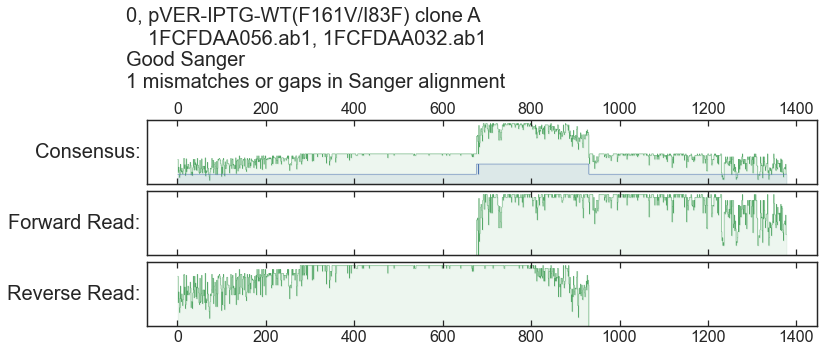

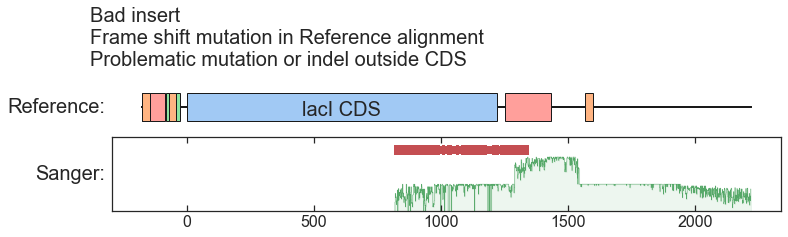

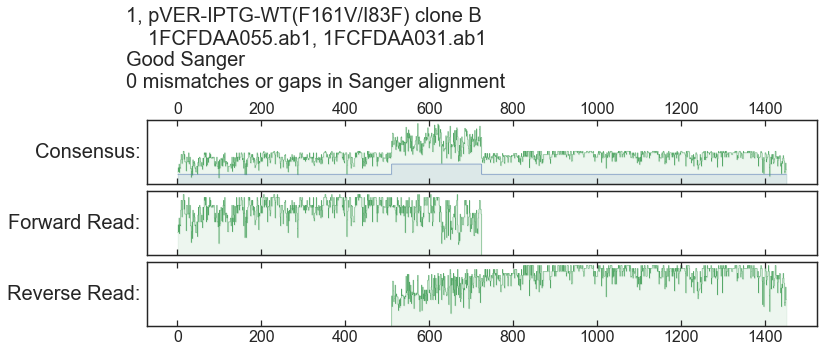

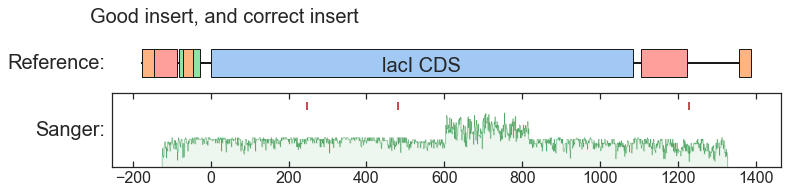

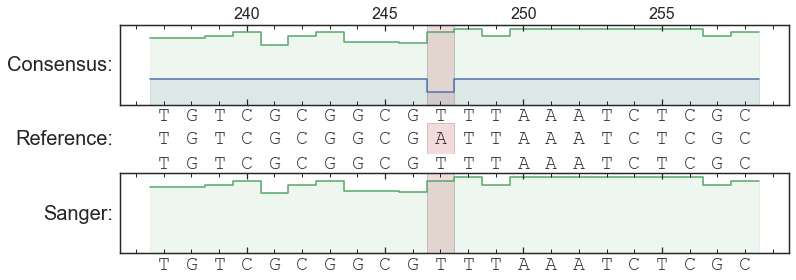

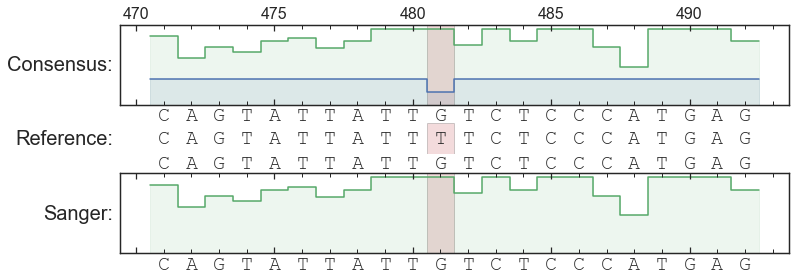

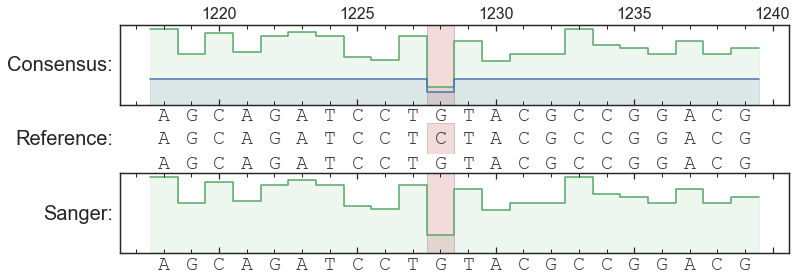

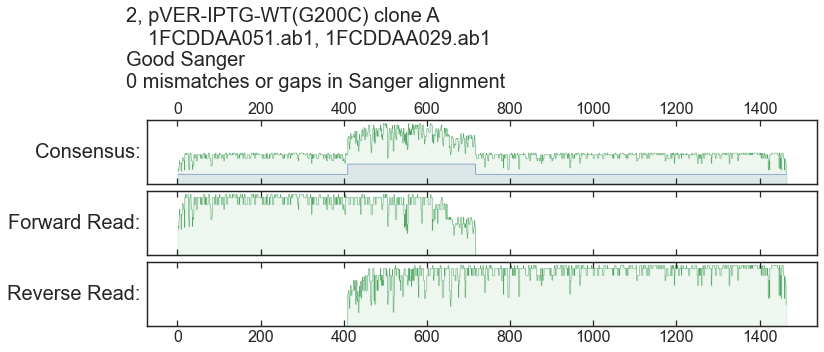

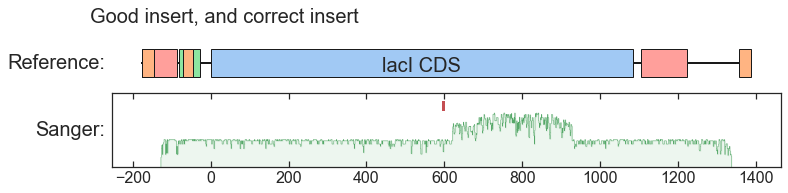

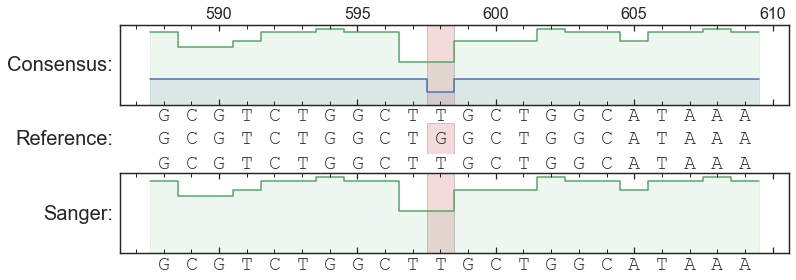

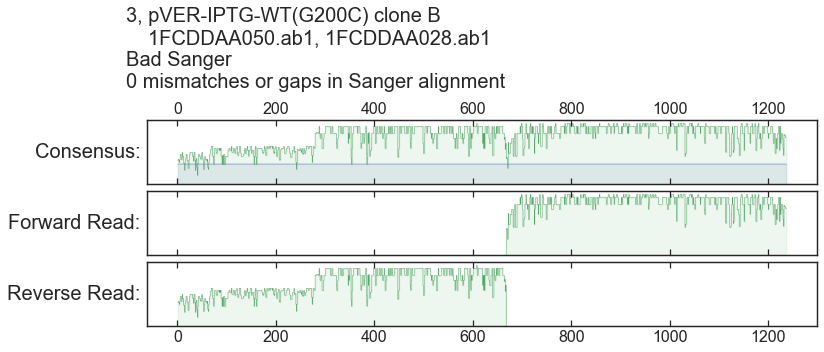

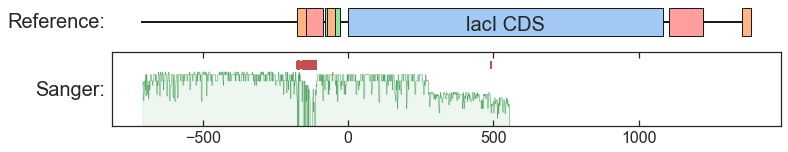

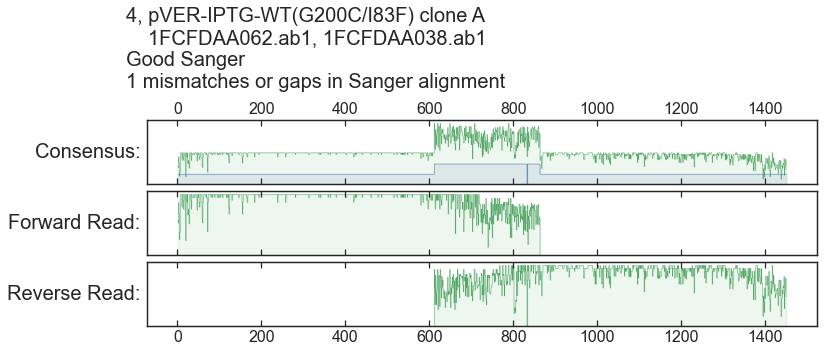

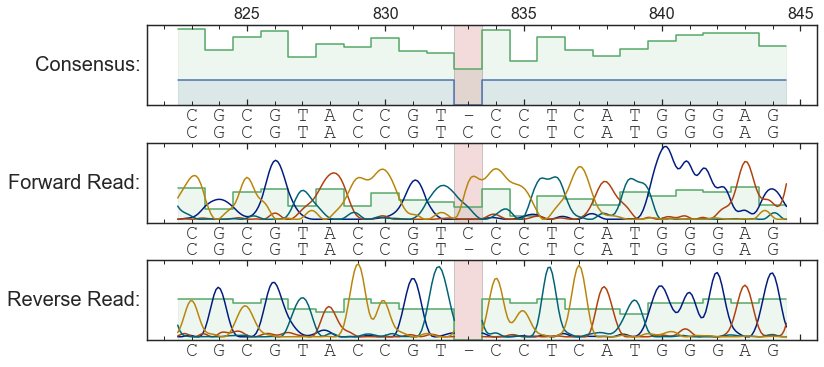

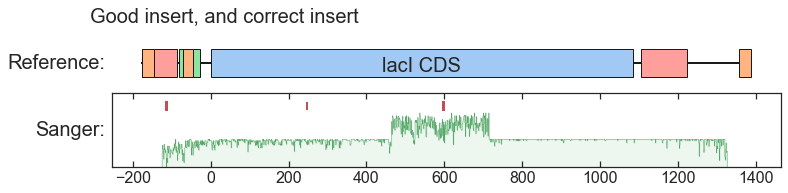

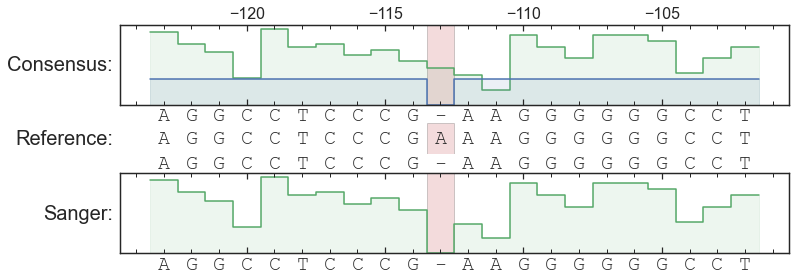

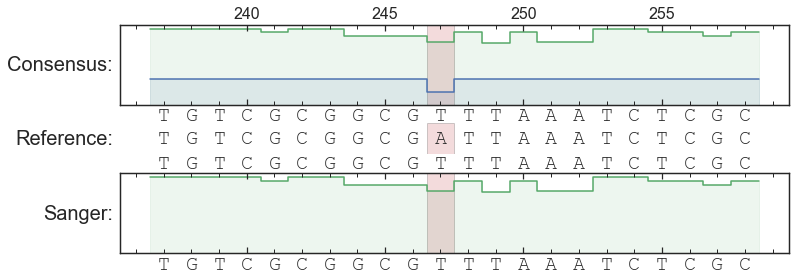

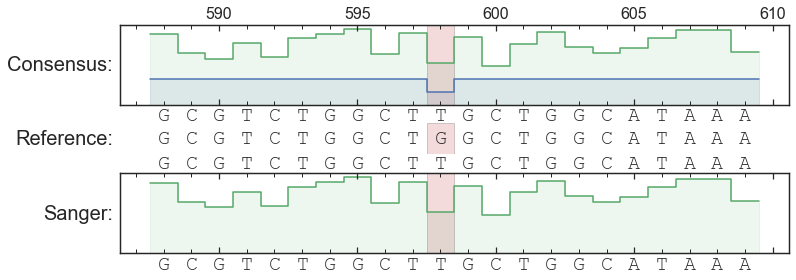

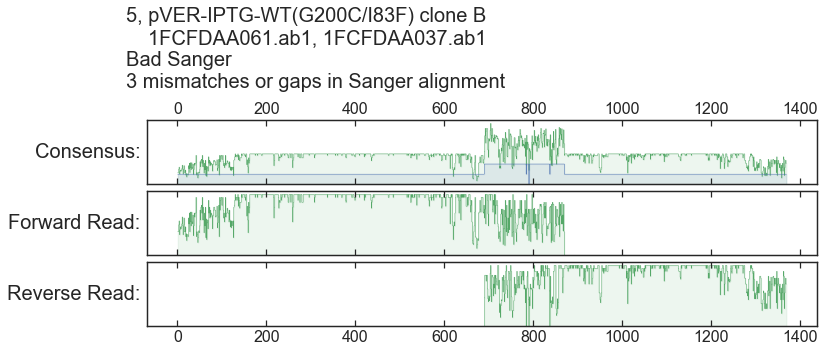

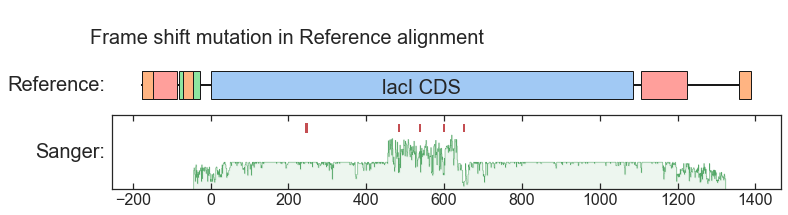

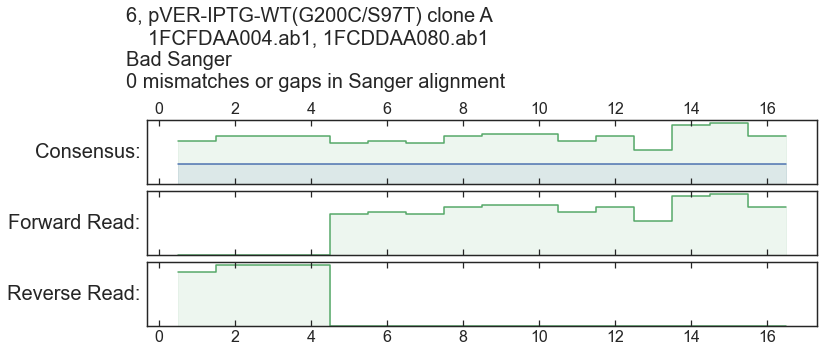

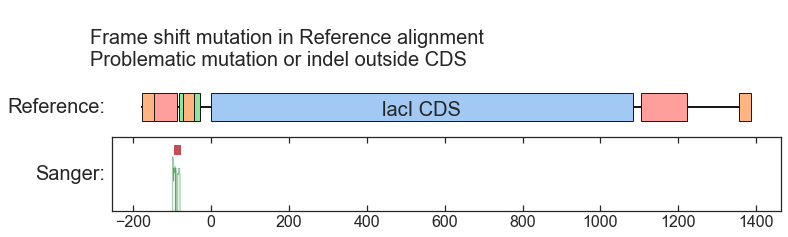

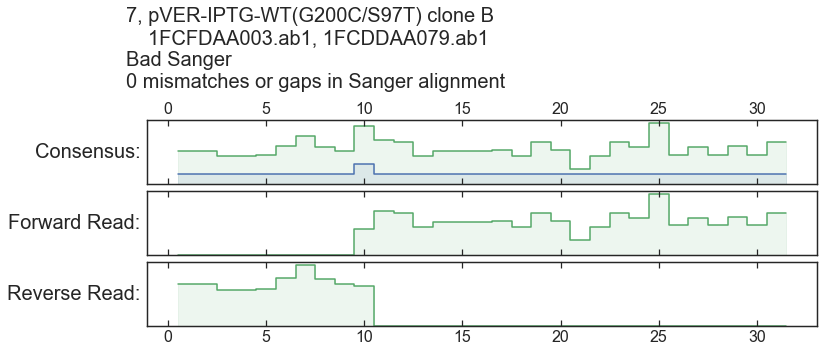

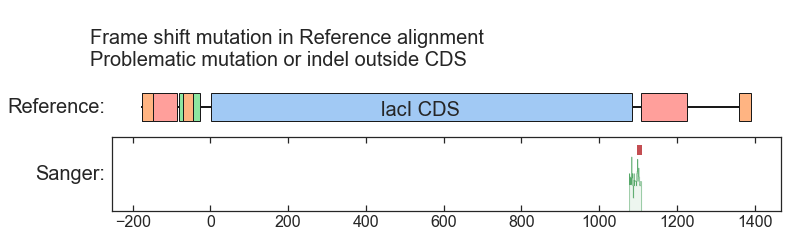

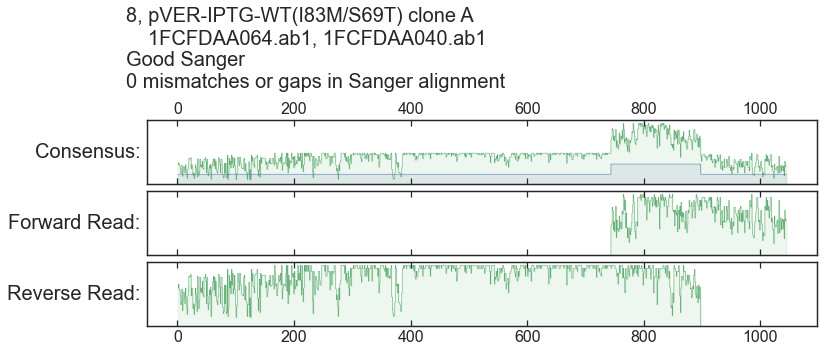

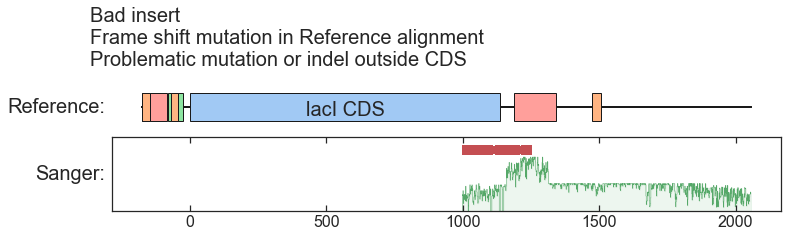

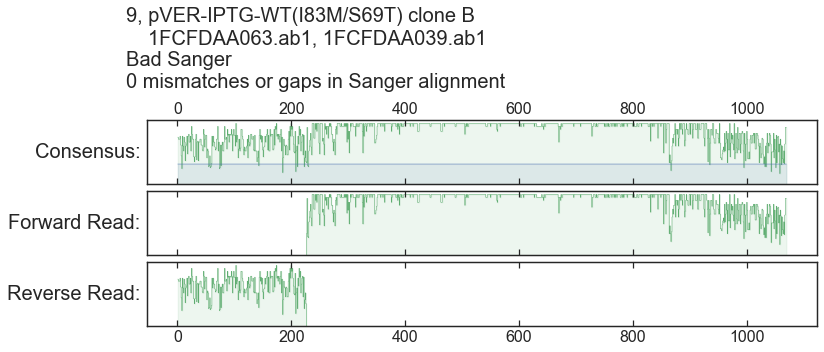

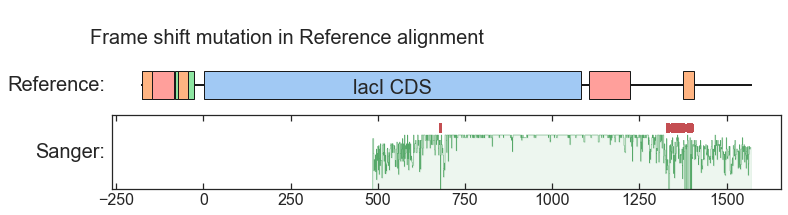

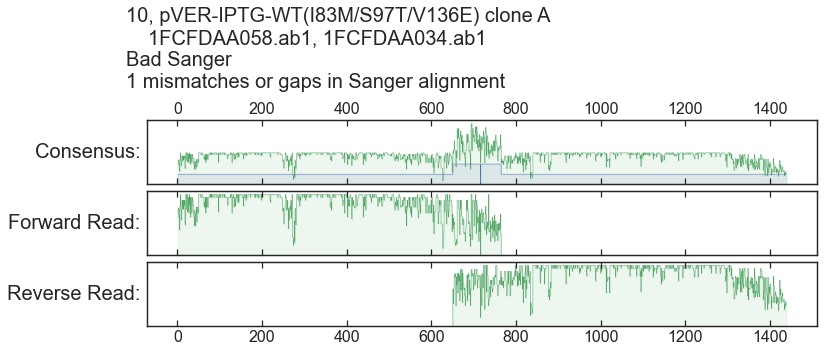

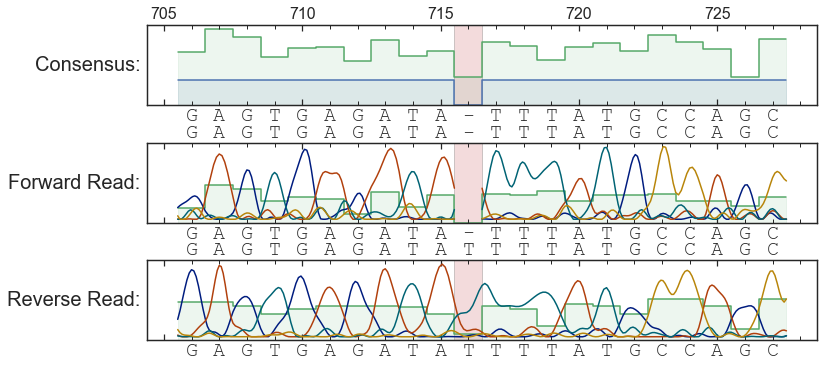

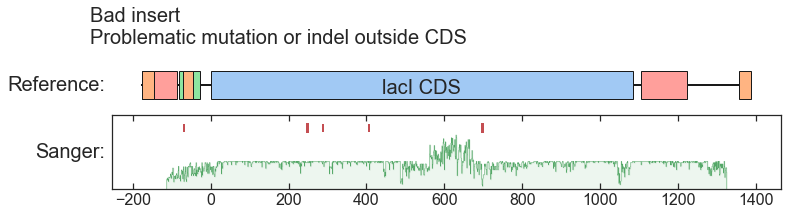

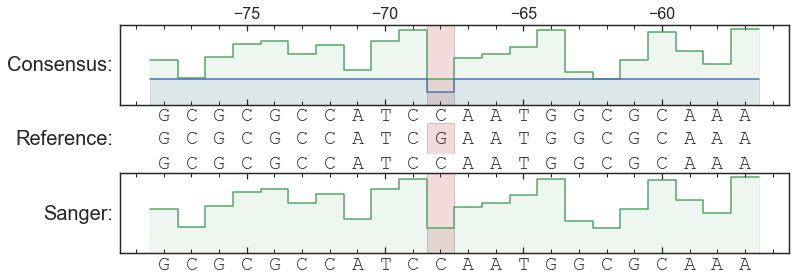

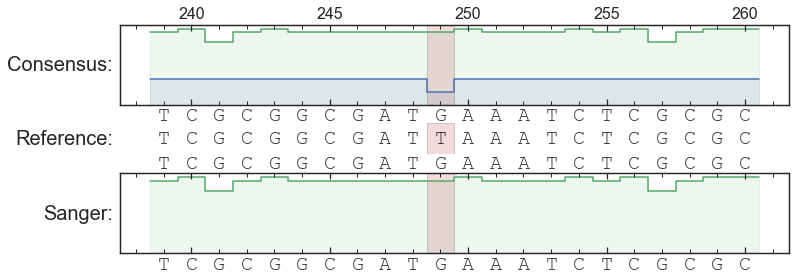

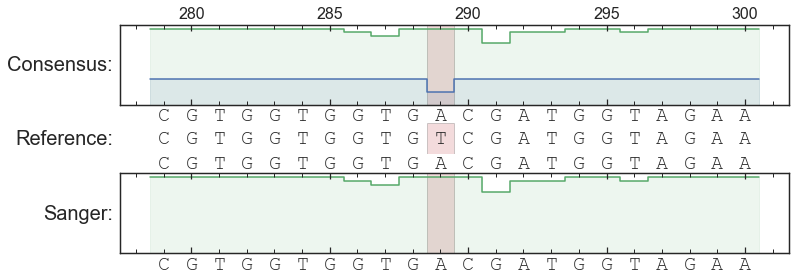

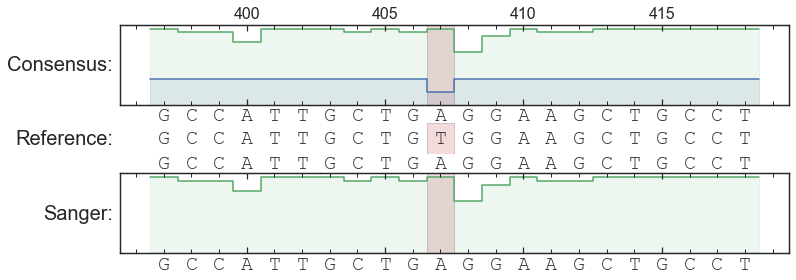

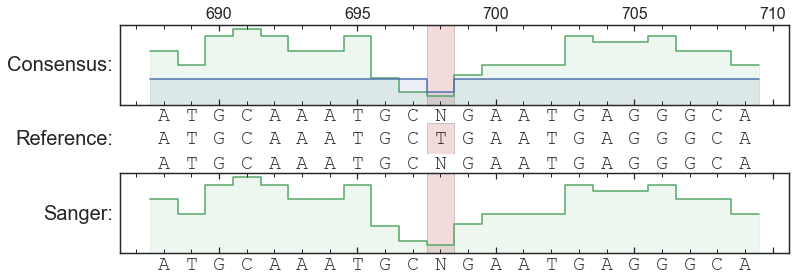

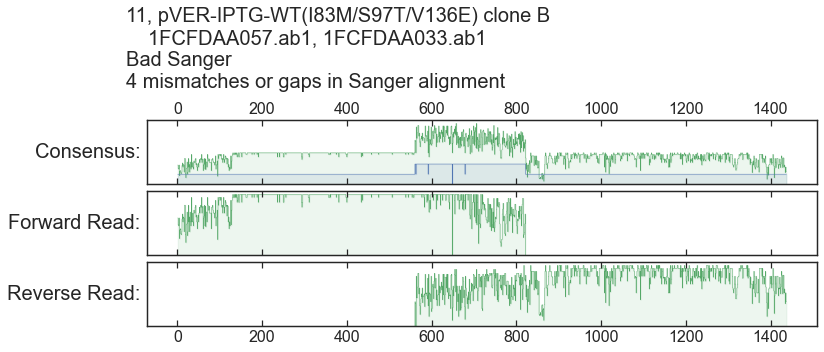

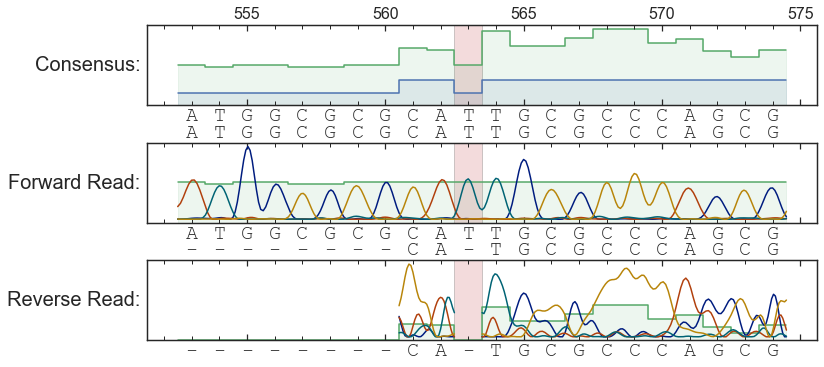

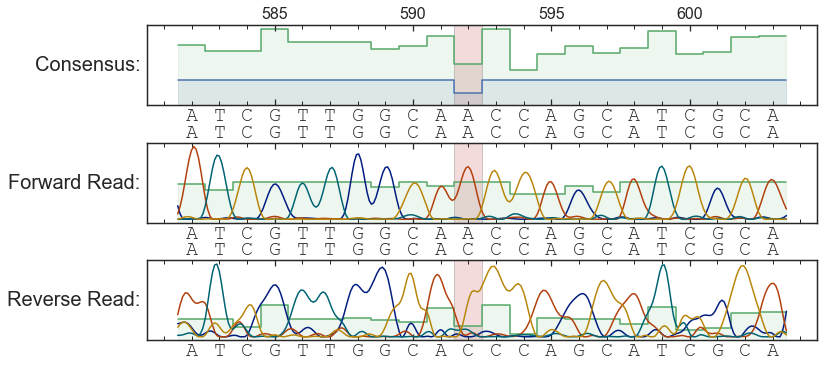

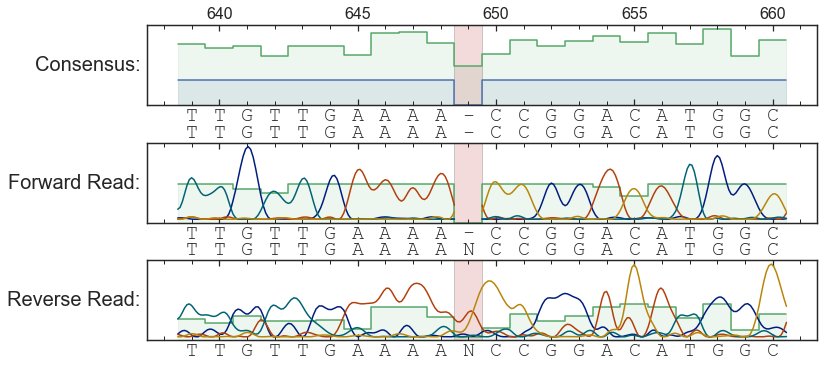

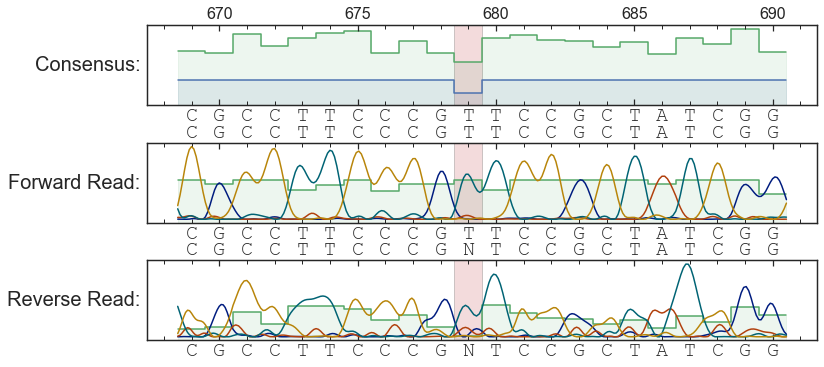

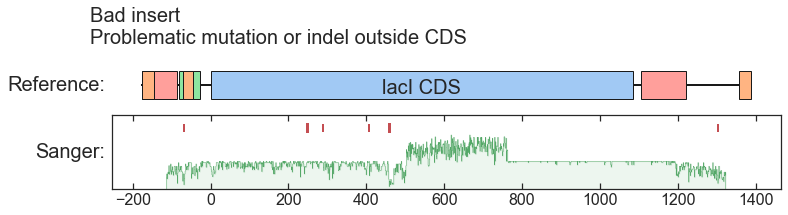

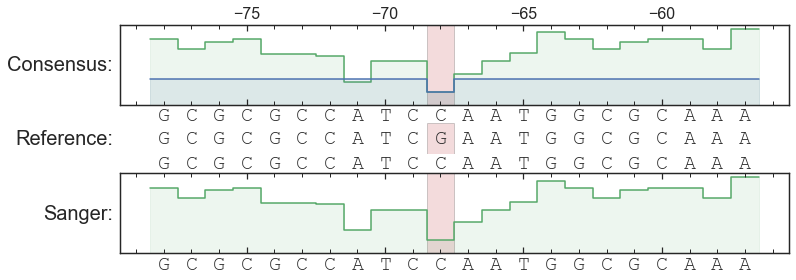

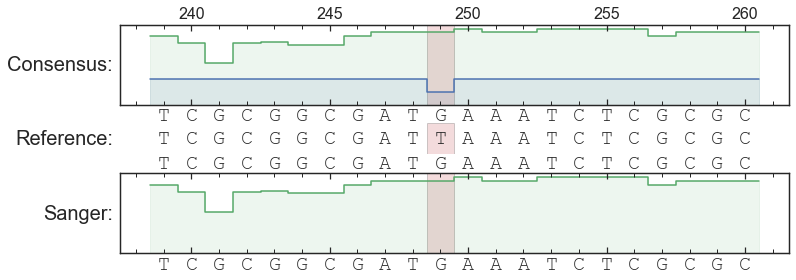

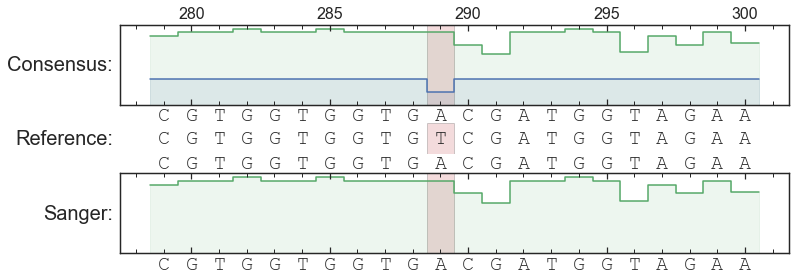

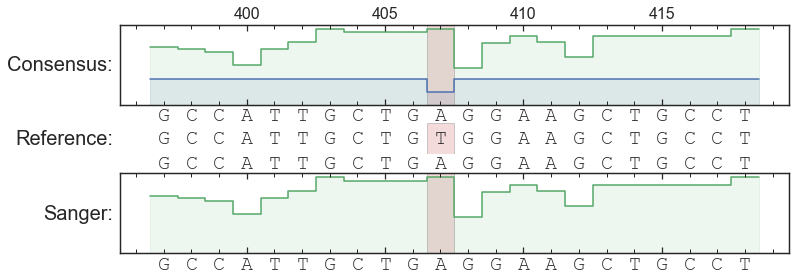

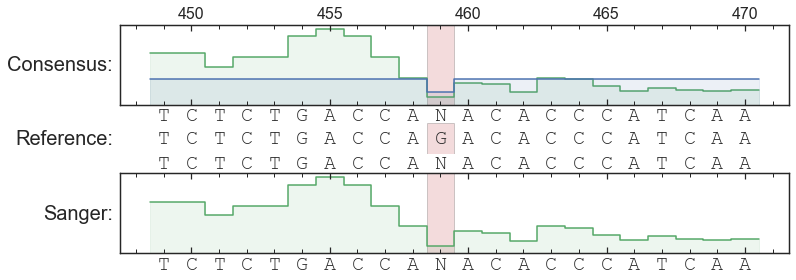

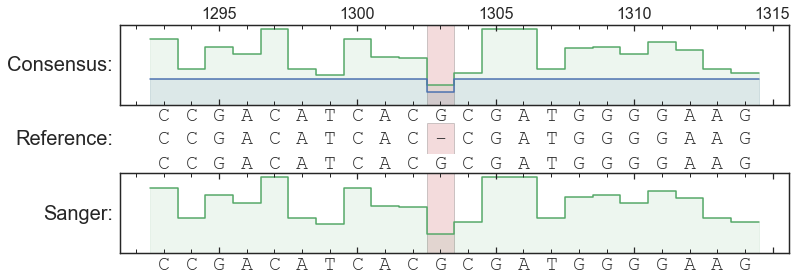

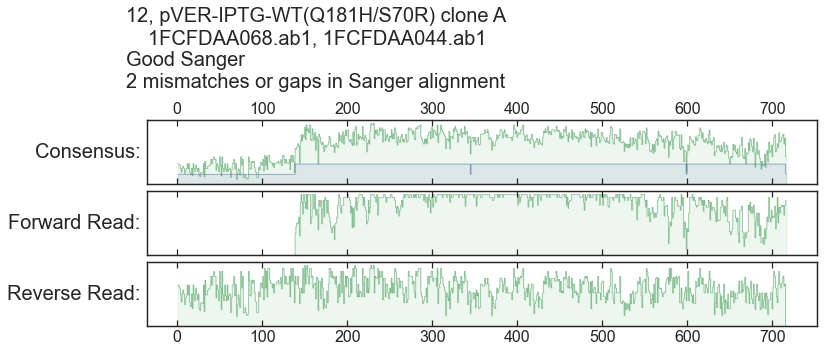

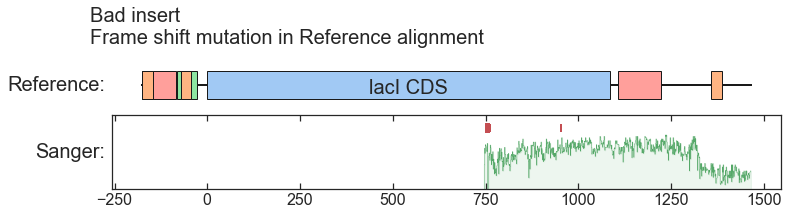

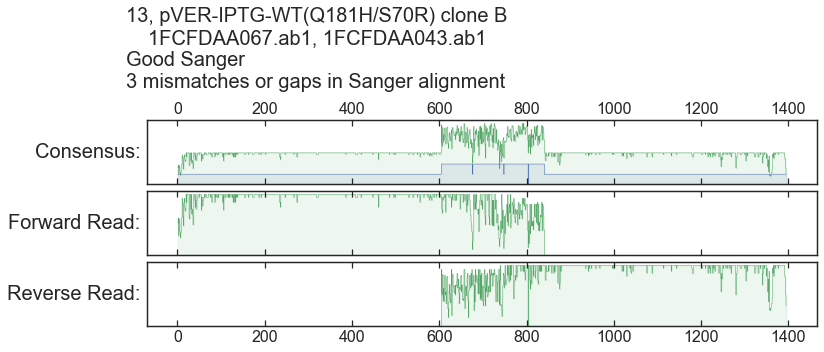

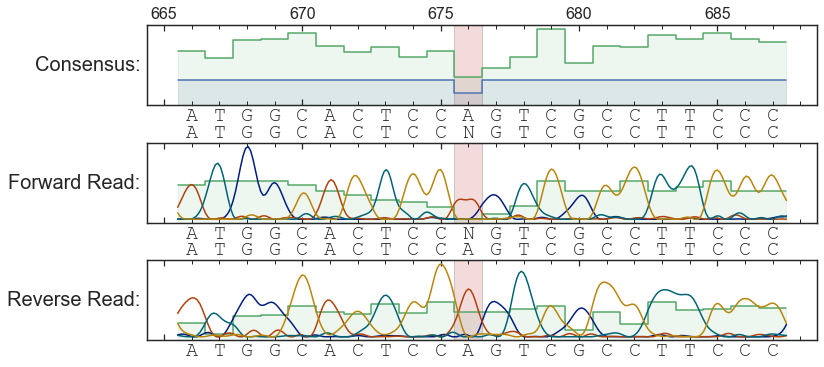

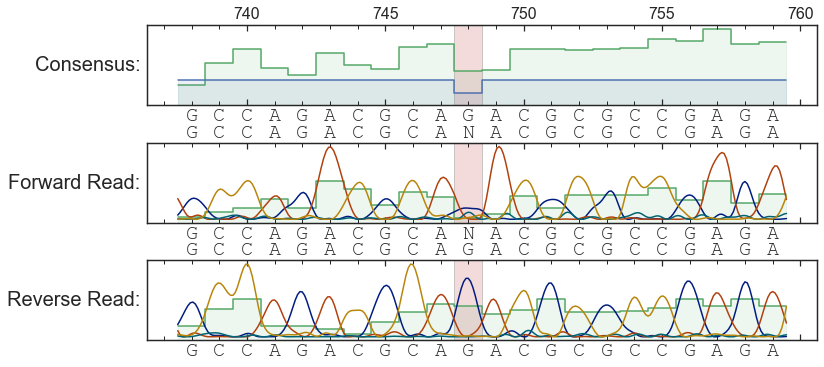

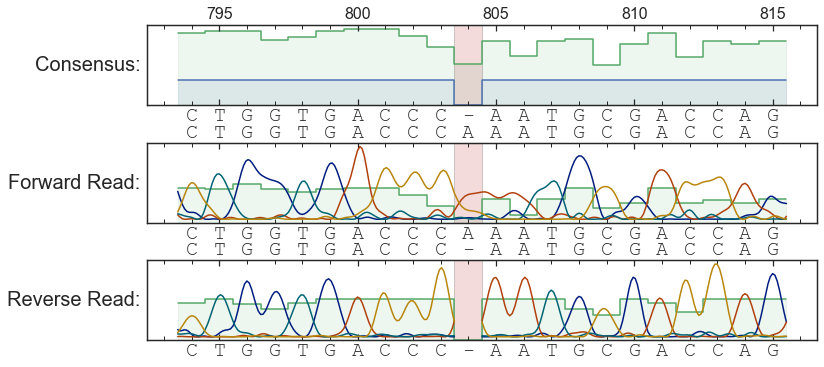

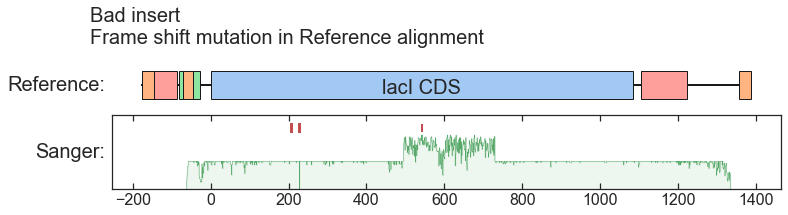

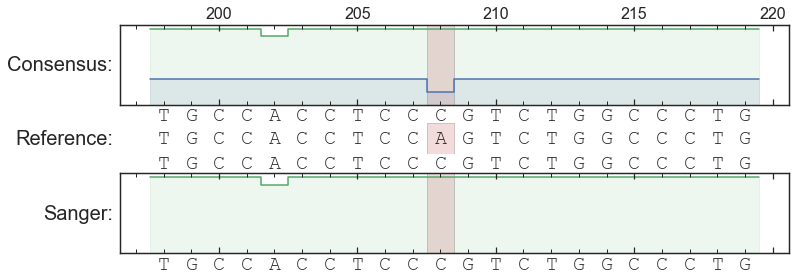

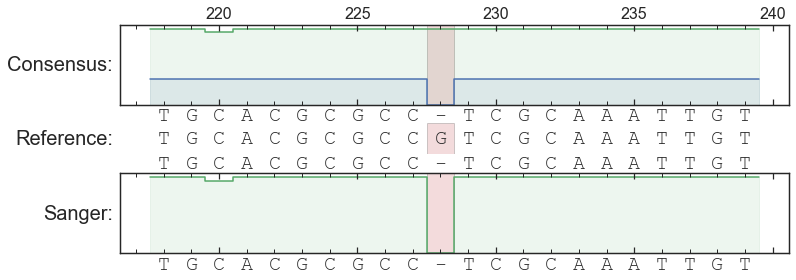

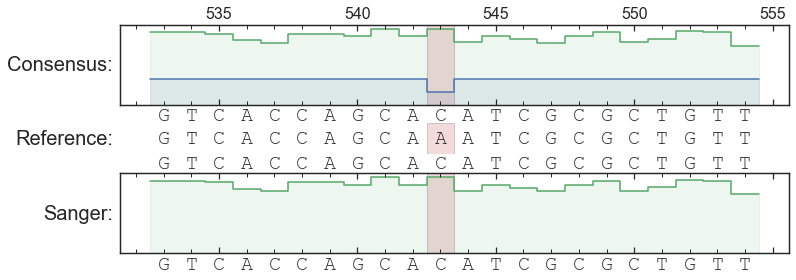

In [26]:
# Plot results
verbose = False
for row_ind, row in align_frame.iterrows():
    a = row.alignment
    f1 = row.forward_sanger_file
    f2 = row.reverse_sanger_file
    
    if a is not None:
        title = f'{row_ind}, {row.variant} clone {row.clone}\n    {f1}, {f2}\n'
        if (row.is_good_sanger):
            title += 'Good Sanger'
        elif (row.is_good_sanger==False):
            title += 'Bad Sanger'
        '''
        if (row.is_good_insert):
            title += ', Good insert, '
            if (row.has_correct_insert):
                title += 'and correct insert'
            else:
                title += f'but wrong insert: {row.substitution_codes}'
        elif (row.is_good_insert==False):
            title += ', Bad insert'
        '''
        
        ref_align = row.ref_alignment
        gap_count = vs.num_gaps(ref_align)
        title += f'\n{len(a.mismatch_ind)} mismatches or gaps in Sanger alignment'
        
        print(title)
        vs.zoom_out_plot(a, title=title, seq1_label='Forward Read:', seq2_label='Reverse Read:')
        
        plot_zoom_in = (row.is_close_insert==True)
        if plot_zoom_in:
            for ind in a.mismatch_ind:
                fig, axs = vs.zoom_in_plot(a, ind, verbose=verbose, seq1_label='Forward Read:', seq2_label='Reverse Read:')
        
        ref_title = ''
        if (row.is_good_insert):
            ref_title += 'Good insert, '
            if (row.has_correct_insert):
                ref_title += 'and correct insert'
            else:
                ref_title += f'but wrong insert: {row.substitution_codes}'
        elif (row.is_good_insert==False):
            ref_title += 'Bad insert'
        
        if (row.gap_in_ref_align==True):
            ref_title += f'\nFrame shift mutation in Reference alignment'
        if (row.bad_mutation==True):
            ref_title += f'\nProblematic mutation or indel outside CDS'
        print(ref_title)
        vs.compare_to_ref_plot(ref_align, anchor_feature='lacI CDS', title=ref_title);
        
        if plot_zoom_in:
            zoom_in_list = [list(group) for group in more_itertools.consecutive_groups(ref_align.mismatch_ind)]
            zoom_in_list = [slice(x[0], x[-1]+1) for x in zoom_in_list]
            for ind in zoom_in_list:
                fig, axs = vs.zoom_in_plot(ref_align, ind, verbose=verbose, seq1_label='Reference:', seq2_label='Sanger:',
                                           include_chromatograms=False, compare_to_ref=True, anchor_feature='lacI CDS')

        plt.rcParams["figure.figsize"] = [12, 0.1]
        fig, axs = plt.subplots()
        axs.set_axis_off()

        align_frame.loc[row_ind, 'plotted'] = True

        print()

1, pVER-IPTG-WT(F161V/I83F) clone B
    1FCFDAA055.ab1, 1FCFDAA031.ab1
Good Sanger
0 mismatches or gaps in Sanger alignment
Good insert, and correct insert

2, pVER-IPTG-WT(G200C) clone A
    1FCDDAA051.ab1, 1FCDDAA029.ab1
Good Sanger
0 mismatches or gaps in Sanger alignment
Good insert, and correct insert

4, pVER-IPTG-WT(G200C/I83F) clone A
    1FCFDAA062.ab1, 1FCFDAA038.ab1
Good Sanger
1 mismatches or gaps in Sanger alignment
Good insert, and correct insert



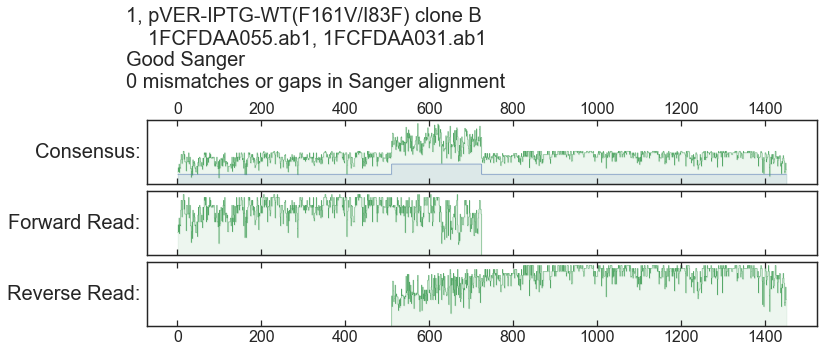

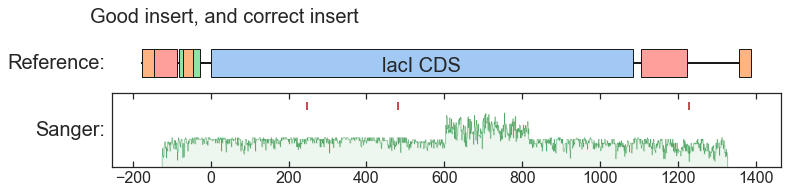

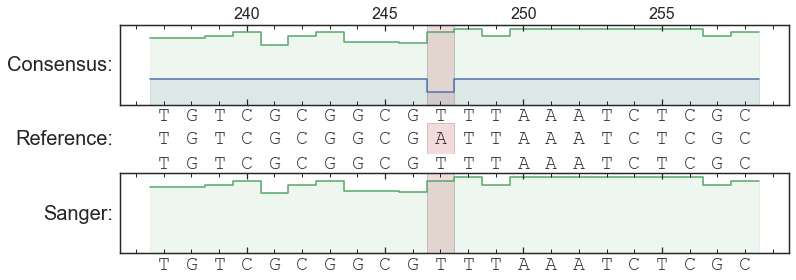

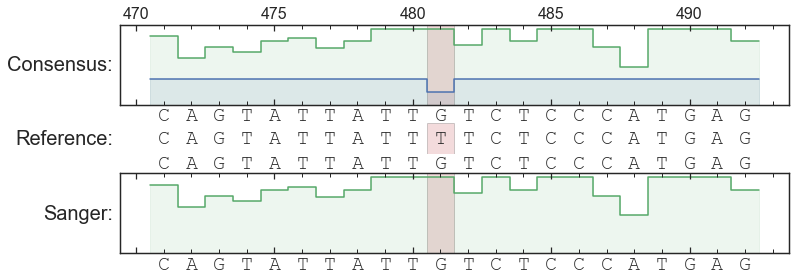

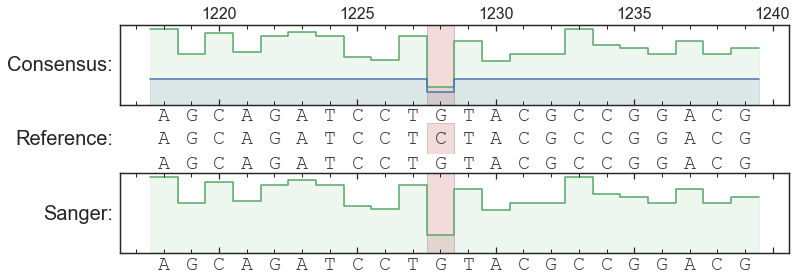

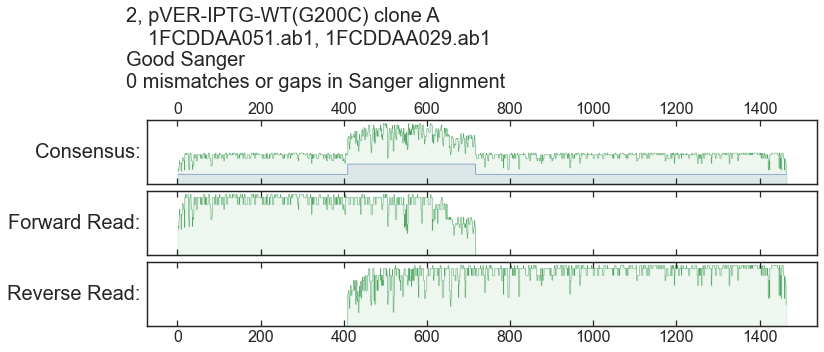

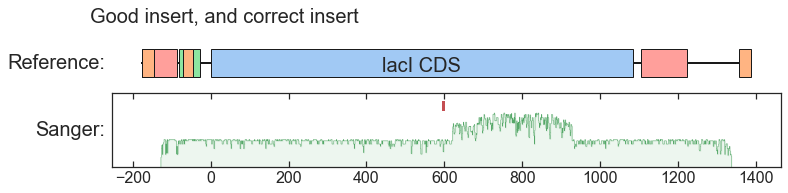

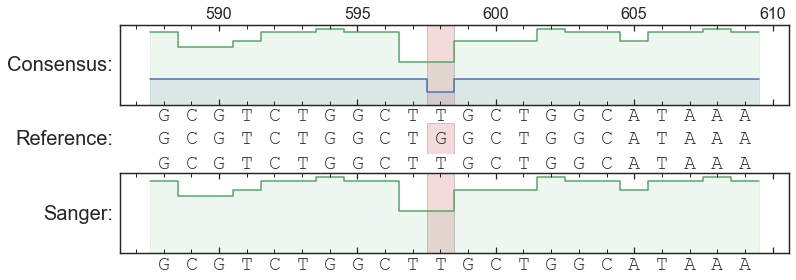

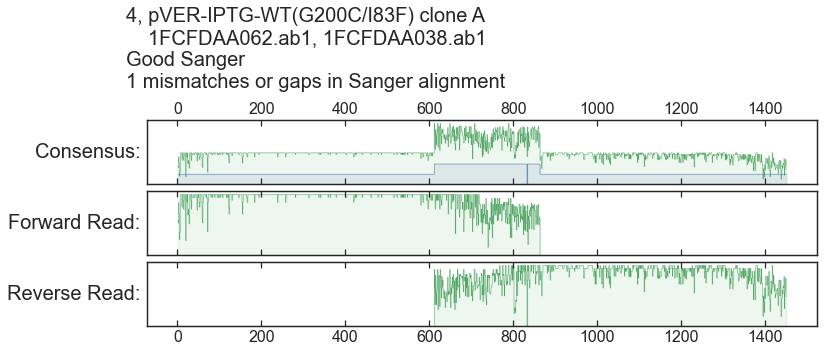

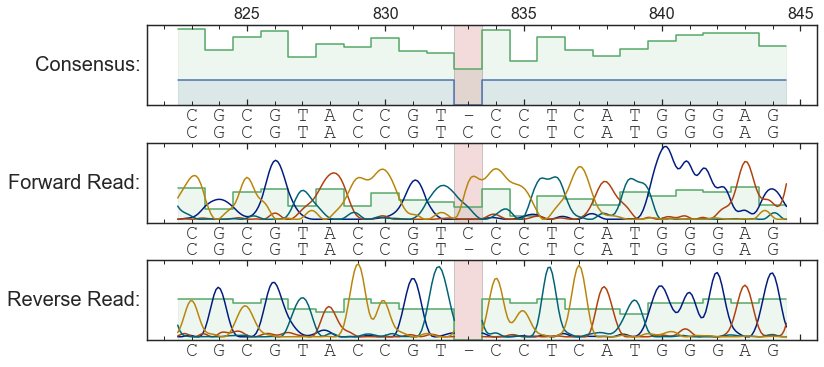

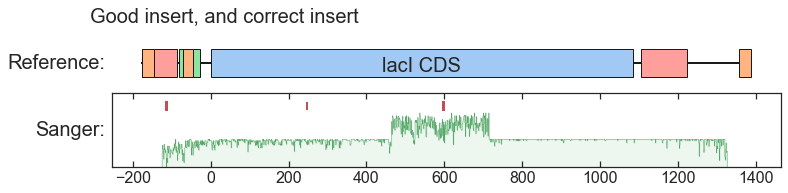

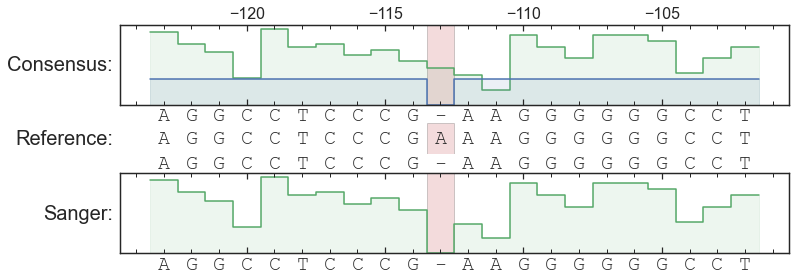

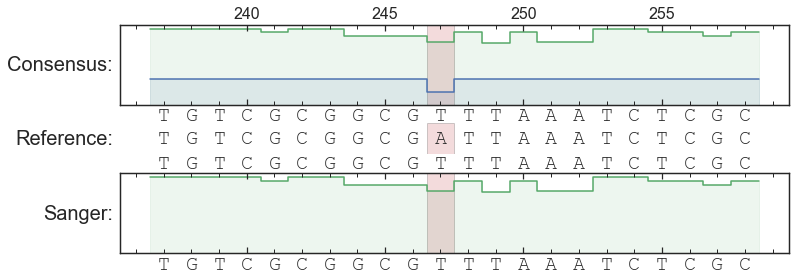

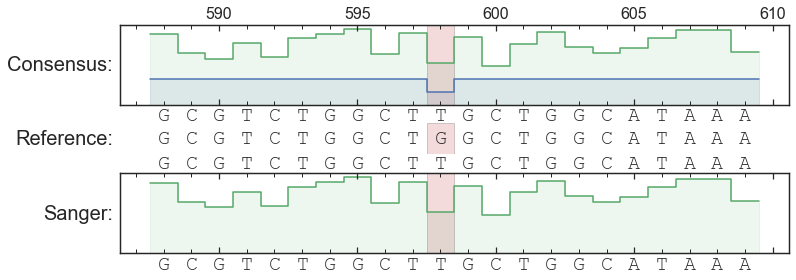

In [27]:
# Plot results - for "correct instert" - make sure to look carefully to avoid false positives
verbose = False
for row_ind, row in align_frame.iterrows():
    a = row.alignment
    f1 = row.forward_sanger_file
    f2 = row.reverse_sanger_file
    
    if (a is not None) and (row.has_correct_insert):
        title = f'{row_ind}, {row.variant} clone {row.clone}\n    {f1}, {f2}\n'
        if (row.is_good_sanger):
            title += 'Good Sanger'
        elif (row.is_good_sanger==False):
            title += 'Bad Sanger'
        '''
        if (row.is_good_insert):
            title += ', Good insert, '
            if (row.has_correct_insert):
                title += 'and correct insert'
            else:
                title += f'but wrong insert: {row.substitution_codes}'
        elif (row.is_good_insert==False):
            title += ', Bad insert'
        '''
        
        ref_align = row.ref_alignment
        gap_count = vs.num_gaps(ref_align)
        title += f'\n{len(a.mismatch_ind)} mismatches or gaps in Sanger alignment'
        
        print(title)
        vs.zoom_out_plot(a, title=title, seq1_label='Forward Read:', seq2_label='Reverse Read:')
        
        plot_zoom_in = (row.is_close_insert==True)
        if plot_zoom_in:
            for ind in a.mismatch_ind:
                fig, axs = vs.zoom_in_plot(a, ind, verbose=verbose, seq1_label='Forward Read:', seq2_label='Reverse Read:')
        
        ref_title = ''
        if (row.is_good_insert):
            ref_title += 'Good insert, '
            if (row.has_correct_insert):
                ref_title += 'and correct insert'
            else:
                ref_title += f'but wrong insert: {row.substitution_codes}'
        elif (row.is_good_insert==False):
            ref_title += 'Bad insert'
        
        if (row.gap_in_ref_align==True):
            ref_title += f'\nFrame shift mutation in Reference alignment'
        if (row.bad_mutation==True):
            ref_title += f'\nProblematic mutation or indel outside CDS'
        print(ref_title)
        vs.compare_to_ref_plot(ref_align, anchor_feature='lacI CDS', title=ref_title);
        
        if plot_zoom_in:
            zoom_in_list = [list(group) for group in more_itertools.consecutive_groups(ref_align.mismatch_ind)]
            zoom_in_list = [slice(x[0], x[-1]+1) for x in zoom_in_list]
            for ind in zoom_in_list:
                fig, axs = vs.zoom_in_plot(ref_align, ind, verbose=verbose, seq1_label='Reference:', seq2_label='Sanger:',
                                           include_chromatograms=False, compare_to_ref=True, anchor_feature='lacI CDS')

        plt.rcParams["figure.figsize"] = [12, 0.1]
        fig, axs = plt.subplots()
        axs.set_axis_off()

        align_frame.loc[row_ind, 'plotted'] = True

        print()

0, pVER-IPTG-WT(F161V/I83F) clone A
    1FCFDAA056.ab1, 1FCFDAA032.ab1
Good Sanger
1 mismatches or gaps in Sanger alignment
Bad insert
Frame shift mutation in Reference alignment
Problematic mutation or indel outside CDS

5, pVER-IPTG-WT(G200C/I83F) clone B
    1FCFDAA061.ab1, 1FCFDAA037.ab1
Bad Sanger
3 mismatches or gaps in Sanger alignment

Frame shift mutation in Reference alignment

6, pVER-IPTG-WT(G200C/S97T) clone A
    1FCFDAA004.ab1, 1FCDDAA080.ab1
Bad Sanger
0 mismatches or gaps in Sanger alignment

Frame shift mutation in Reference alignment
Problematic mutation or indel outside CDS

7, pVER-IPTG-WT(G200C/S97T) clone B
    1FCFDAA003.ab1, 1FCDDAA079.ab1
Bad Sanger
0 mismatches or gaps in Sanger alignment

Frame shift mutation in Reference alignment
Problematic mutation or indel outside CDS

8, pVER-IPTG-WT(I83M/S69T) clone A
    1FCFDAA064.ab1, 1FCFDAA040.ab1
Good Sanger
0 mismatches or gaps in Sanger alignment
Bad insert
Frame shift mutation in Reference alignment
Problemat

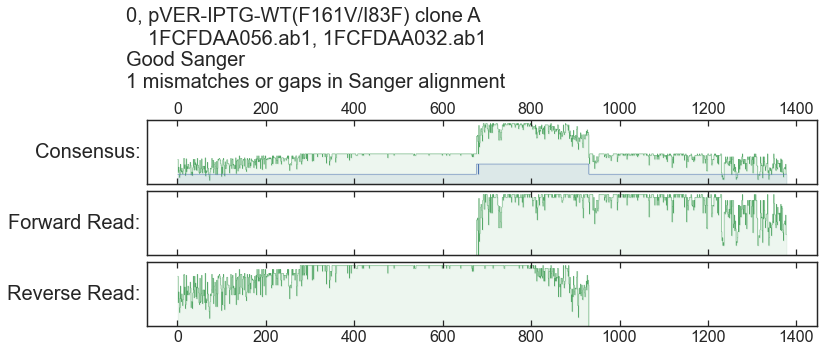

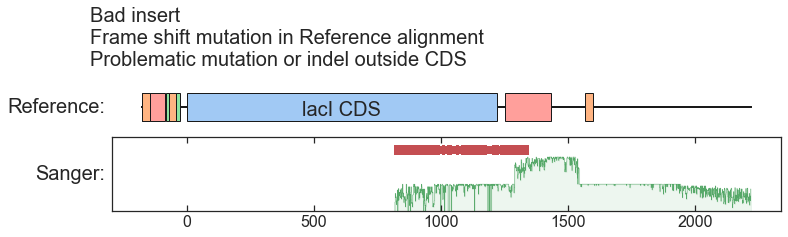

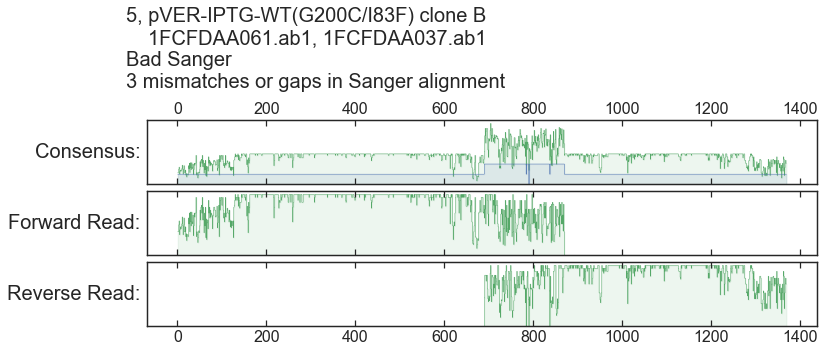

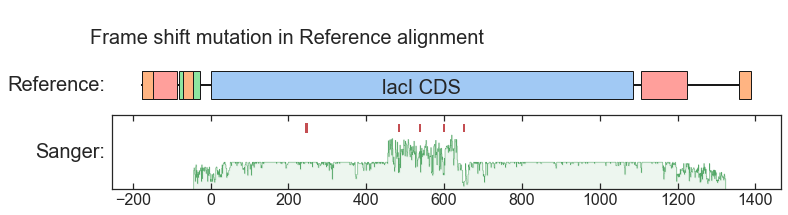

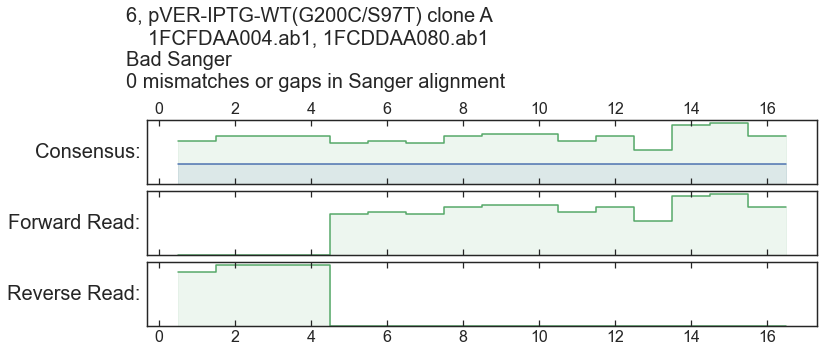

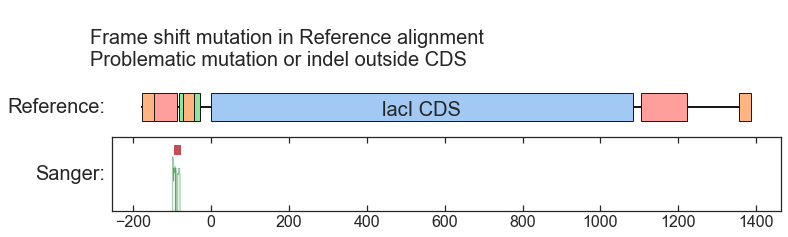

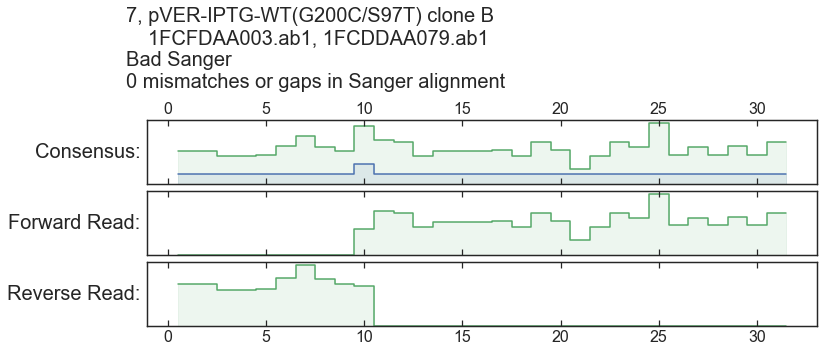

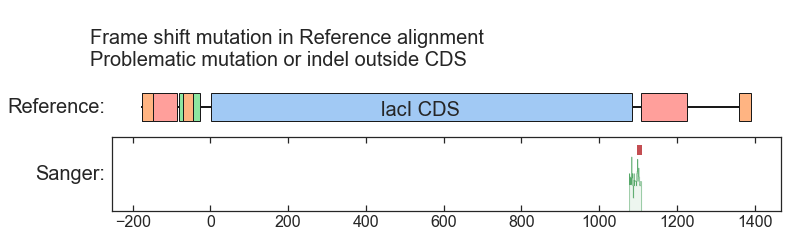

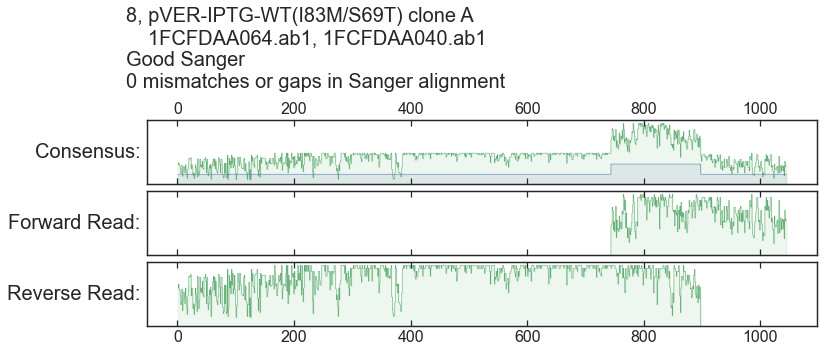

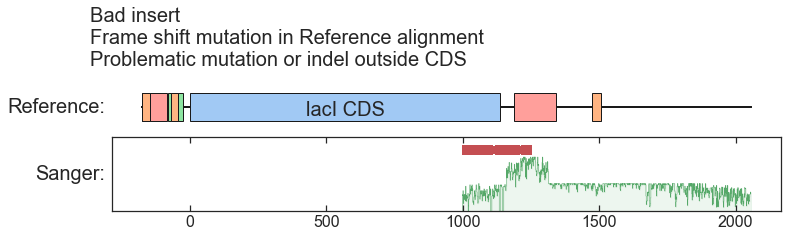

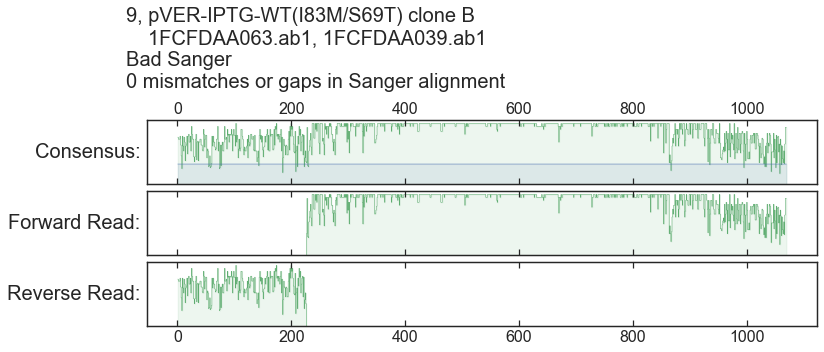

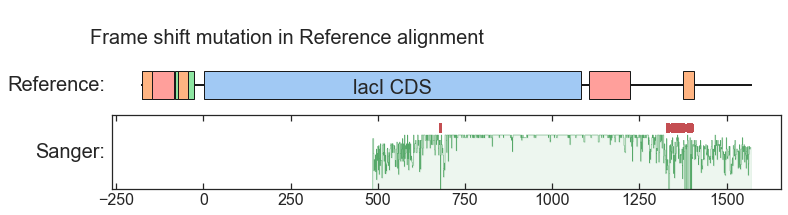

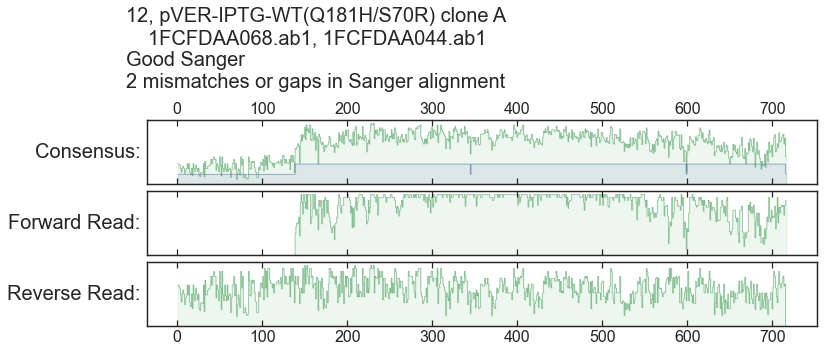

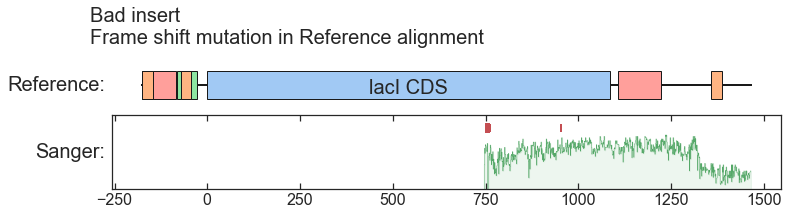

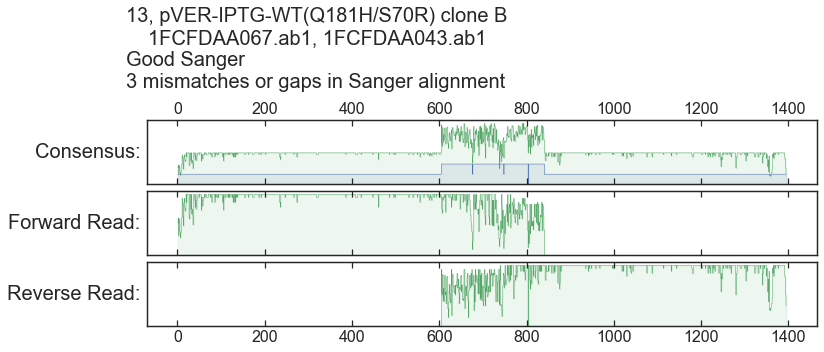

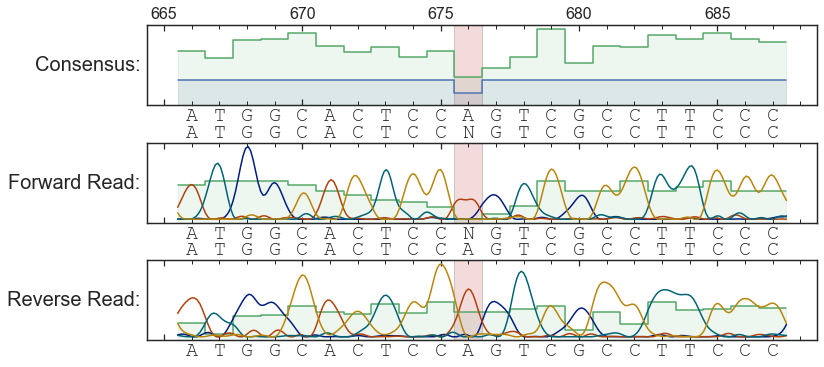

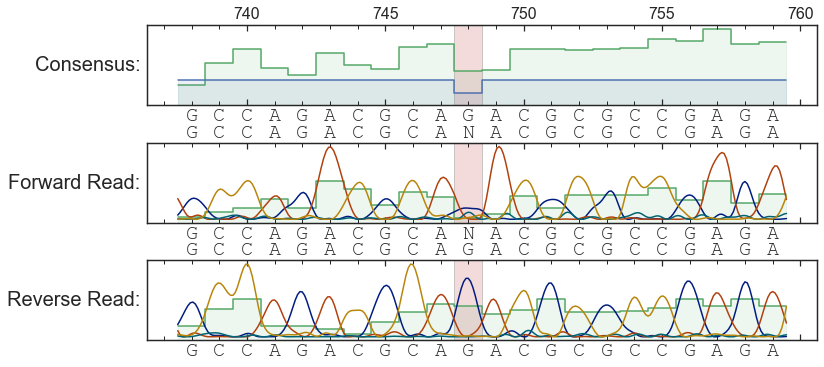

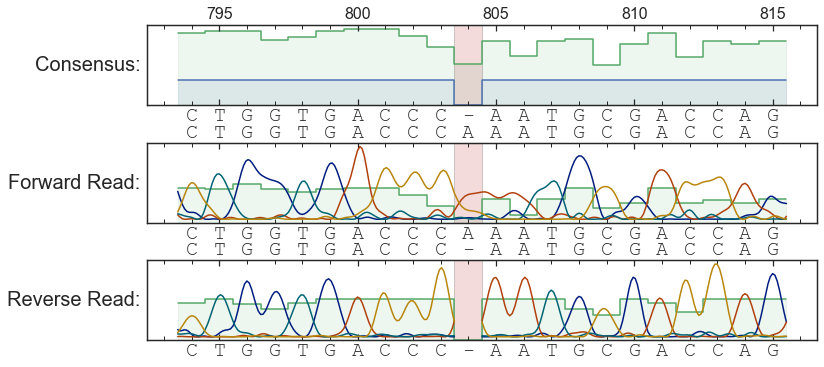

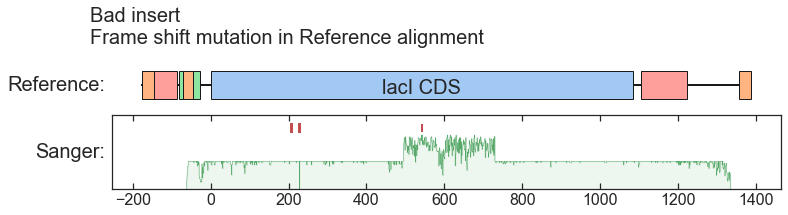

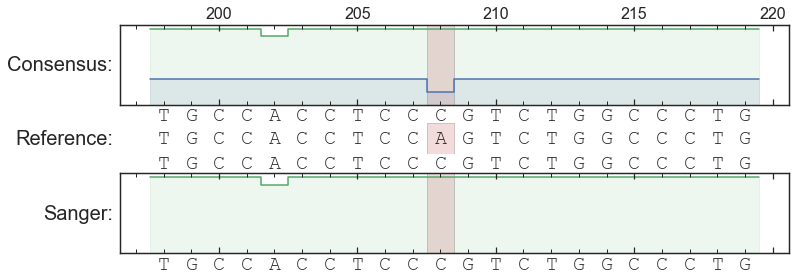

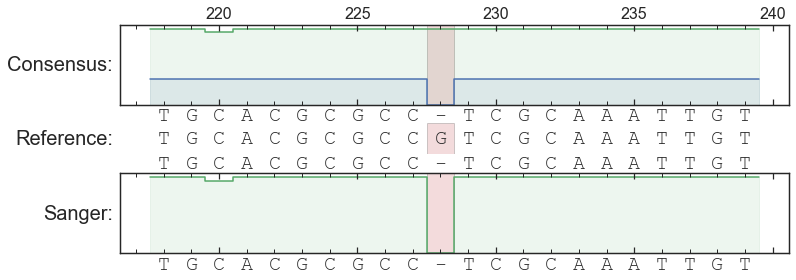

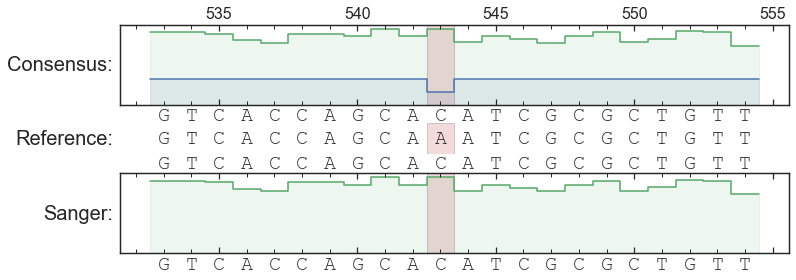

In [28]:
# Plot results - for results with frame shift in reference alignment
verbose = False
for row_ind, row in align_frame.iterrows():
    a = row.alignment
    f1 = row.forward_sanger_file
    f2 = row.reverse_sanger_file
    
    if (a is not None) and (row.gap_in_ref_align==True):
        title = f'{row_ind}, {row.variant} clone {row.clone}\n    {f1}, {f2}\n'
        if (row.is_good_sanger):
            title += 'Good Sanger'
        elif (row.is_good_sanger==False):
            title += 'Bad Sanger'
        '''
        if (row.is_good_insert):
            title += ', Good insert, '
            if (row.has_correct_insert):
                title += 'and correct insert'
            else:
                title += f'but wrong insert: {row.substitution_codes}'
        elif (row.is_good_insert==False):
            title += ', Bad insert'
        '''
        
        ref_align = row.ref_alignment
        gap_count = vs.num_gaps(ref_align)
        title += f'\n{len(a.mismatch_ind)} mismatches or gaps in Sanger alignment'
        
        print(title)
        vs.zoom_out_plot(a, title=title, seq1_label='Forward Read:', seq2_label='Reverse Read:')
        
        plot_zoom_in = (row.is_close_insert==True)
        if plot_zoom_in:
            for ind in a.mismatch_ind:
                fig, axs = vs.zoom_in_plot(a, ind, verbose=verbose, seq1_label='Forward Read:', seq2_label='Reverse Read:')
        
        ref_title = ''
        if (row.is_good_insert):
            ref_title += 'Good insert, '
            if (row.has_correct_insert):
                ref_title += 'and correct insert'
            else:
                ref_title += f'but wrong insert: {row.substitution_codes}'
        elif (row.is_good_insert==False):
            ref_title += 'Bad insert'
        
        if (row.gap_in_ref_align==True):
            ref_title += f'\nFrame shift mutation in Reference alignment'
        if (row.bad_mutation==True):
            ref_title += f'\nProblematic mutation or indel outside CDS'
        print(ref_title)
        vs.compare_to_ref_plot(ref_align, anchor_feature='lacI CDS', title=ref_title);
        
        if plot_zoom_in:
            zoom_in_list = [list(group) for group in more_itertools.consecutive_groups(ref_align.mismatch_ind)]
            zoom_in_list = [slice(x[0], x[-1]+1) for x in zoom_in_list]
            for ind in zoom_in_list:
                fig, axs = vs.zoom_in_plot(ref_align, ind, verbose=verbose, seq1_label='Reference:', seq2_label='Sanger:',
                                           include_chromatograms=False, compare_to_ref=True, anchor_feature='lacI CDS')

        plt.rcParams["figure.figsize"] = [12, 0.1]
        fig, axs = plt.subplots()
        axs.set_axis_off()

        align_frame.loc[row_ind, 'plotted'] = True

        print()

In [29]:
align_frame[align_frame.plotted==False][display_cols]

Empty DataFrame
Columns: [variant, clone, forward_sanger_file, reverse_sanger_file, sanger_start, is_good_sanger, is_good_insert, gap_in_ref_align, bad_mutation, substitution_codes, indel_codes, has_correct_insert]
Index: []

In [30]:
out_frame = align_frame[align_frame.plotted==True][display_cols].copy()
good_clone = []
redo_sanger = []
for ind, row in out_frame.iterrows():
    g_cl = ''
    re_sang = ''
    if (row.has_correct_insert==True):
        g_cl = 'Yes'
        re_sang = 'No'
    elif (row.has_correct_insert==False):
        g_cl = 'No'
        re_sang = 'No'
    elif (row.is_good_sanger==True) and (row.is_good_insert==False):
        g_cl = 'No'
        re_sang = 'No'
    elif (row.is_good_sanger==False):
        re_sang = 'Yes'
        
    good_clone.append(g_cl)
    redo_sanger.append(re_sang)
        
out_frame['good_clone'] = good_clone
out_frame['redo_sanger'] = redo_sanger
out_frame.sort_values(by=['variant', 'clone', 'sanger_start'], inplace=True)
out_frame

variant clone forward_sanger_file  \
0        pVER-IPTG-WT(F161V/I83F)     A      1FCFDAA056.ab1   
1        pVER-IPTG-WT(F161V/I83F)     B      1FCFDAA055.ab1   
2             pVER-IPTG-WT(G200C)     A      1FCDDAA051.ab1   
3             pVER-IPTG-WT(G200C)     B      1FCDDAA050.ab1   
4        pVER-IPTG-WT(G200C/I83F)     A      1FCFDAA062.ab1   
5        pVER-IPTG-WT(G200C/I83F)     B      1FCFDAA061.ab1   
6        pVER-IPTG-WT(G200C/S97T)     A      1FCFDAA004.ab1   
7        pVER-IPTG-WT(G200C/S97T)     B      1FCFDAA003.ab1   
8         pVER-IPTG-WT(I83M/S69T)     A      1FCFDAA064.ab1   
9         pVER-IPTG-WT(I83M/S69T)     B      1FCFDAA063.ab1   
10  pVER-IPTG-WT(I83M/S97T/V136E)     A      1FCFDAA058.ab1   
11  pVER-IPTG-WT(I83M/S97T/V136E)     B      1FCFDAA057.ab1   
12       pVER-IPTG-WT(Q181H/S70R)     A      1FCFDAA068.ab1   
13       pVER-IPTG-WT(Q181H/S70R)     B      1FCFDAA067.ab1   

   reverse_sanger_file         sanger_start  is_good_sanger is_good_insert  \
0       1FCFDAA032.ab1  2021-04-26 19:59:48            True          False   
1       1FCFDAA031.ab1  2021-04-26 19:59:48            True           True   
2       1FCDDAA029.ab1  2021-05-14 02:41:37            True           True   
3       1FCDDAA028.ab1  2021-05-14 02:41:37           False           None   
4       1FCFDAA038.ab1  2021-04-26 19:59:48            True           True   
5       1FCFDAA037.ab1  2021-04-26 19:59:48           False           None   
6       1FCDDAA080.ab1  2021-05-05 22:53:10           False           None   
7       1FCDDAA079.ab1  2021-05-05 22:53:10           False           None   
8       1FCFDAA040.ab1  2021-04-26 19:59:48            True          False   
9       1FCFDAA039.ab1  2021-04-26 19:59:48           False           None   
10      1FCFDAA034.ab1  2021-04-26 19:59:48           False          False   
11      1FCFDAA033.ab1  2021-04-26 19:59:48           False          False   
12      1FCFDAA044.ab1  2021-04-26 19:59:48            True          False   
13      1FCFDAA043.ab1  2021-04-26 19:59:48            True          False   

    gap_in_ref_align  bad_mutation substitution_codes indel_codes  \
0               True          True                 []          []   
1              False         False      [I83F, F161V]          []   
2              False         False            [G200C]          []   
3              False         False                 []          []   
4              False         False      [I83F, G200C]          []   
5               True         False                 []          []   
6               True          True                 []          []   
7               True          True                 []          []   
8               True          True                 []          []   
9               True         False                 []          []   
10             False          True                 []          []   
11             False          True                 []          []   
12              True         False                 []          []   
13              True         False                 []          []   

   has_correct_insert good_clone redo_sanger  
0                None         No          No  
1                True        Yes          No  
2                True        Yes          No  
3                None                    Yes  
4                True        Yes          No  
5                None                    Yes  
6                None                    Yes  
7                None                    Yes  
8                None         No          No  
9                None                    Yes  
10               None                    Yes  
11               None                    Yes  
12               None         No          No  
13               None         No          No

In [31]:
os.chdir(notebook_dir)
file = clone_file[:-4] + '_report.csv'
out_frame.to_csv(file, index=False)
file

'Sanger clones_report.csv'

In [32]:
align_frame[ [x is None for x in align_frame.alignment] ]

Empty DataFrame
Columns: [variant, clone, forward_sanger_file, reverse_sanger_file, alignment, is_good_sanger, sanger_start, ref_alignment, is_close_insert, is_good_insert, gap_in_ref_align, bad_mutation, substitution_codes, indel_codes, has_correct_insert, plotted]
Index: []